<a href="https://colab.research.google.com/github/AgastyaPatel/cits4012-group/blob/vistesting/CITS4012_Group_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLP GROUP ASSIGNMENT (Group 18)

In [87]:
import json
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
from collections import Counter


nltk.download("punkt")
nltk.download("wordnet")
nltk.download("all")
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_eng is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_percep

# Project Setup

In [88]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Add the folder as shortcut to your drive to `nlp_grp` if you don't want to change the following cell (Mount configuration).

> Make sure to add the shortcut inside a folder because colab fails to locate shortcut at the root level in `MyDrive`

SourceFolder = "https://drive.google.com/drive/folders/1b3YNNtStoUhGI2F-VUf6RLp1lsoD2Mz_?usp=share_link".   
Then update the sourceFolder variable

In [89]:
import os
os.environ["sourceFolder"] = "/content/drive/MyDrive/nlp_grp/NLP Group Assignment (Group 18)"

In [90]:
from pathlib import Path
import os

# Replace the folder with the path
sourceFolder = Path(os.environ.get("sourceFolder"))
Files_Required = ["train.json", "test.json", "validation.json",
                  "train_formatted.json", "test_formatted.json", "validation_formatted.json"]
if os.path.exists(sourceFolder):
  pass
else:
  raise FileNotFoundError("Source Folder could not be found. please check mounting of the drive")

for file in Files_Required:
    file_path = sourceFolder/file
    if os.path.exists(file_path):
        print(f"Found {file_path}")
    else:
        raise FileNotFoundError(f"File {file} could not be found. please check mounting of the drive")

Found /content/drive/MyDrive/nlp_grp/NLP Group Assignment (Group 18)/train.json
Found /content/drive/MyDrive/nlp_grp/NLP Group Assignment (Group 18)/test.json
Found /content/drive/MyDrive/nlp_grp/NLP Group Assignment (Group 18)/validation.json
Found /content/drive/MyDrive/nlp_grp/NLP Group Assignment (Group 18)/train_formatted.json
Found /content/drive/MyDrive/nlp_grp/NLP Group Assignment (Group 18)/test_formatted.json
Found /content/drive/MyDrive/nlp_grp/NLP Group Assignment (Group 18)/validation_formatted.json


In [91]:
train_formatted_file = sourceFolder/"train_formatted.json"
test_formatted_file = sourceFolder/"test_formatted.json"
validation_formatted_file = sourceFolder/"validation_formatted.json"

Downloading the gloveTokenizer to the drive. You don't have to redownload it. Skip the next cell

In [92]:
glove_dir = Path(sourceFolder) / "glove"
zip_path = Path(sourceFolder) / "glove.6B.zip"

# Check if GloVe folder exists
if glove_dir.exists():
    print(f"GloVe folder already exists at: {glove_dir}")
else:
    print("GloVe not found. Downloading and extracting...")

    # Download zip only if missing
    if not zip_path.exists():
        !wget http://nlp.stanford.edu/data/glove.6B.zip -O "{zip_path}"

    # Extract to target folder
    !unzip -q "{zip_path}" -d "{glove_dir}"

    print(f"Extraction complete. Files available at: {glove_dir}")

GloVe folder already exists at: /content/drive/MyDrive/nlp_grp/NLP Group Assignment (Group 18)/glove


In [93]:
# Check if the glove tokenizer is present in the sourceFolder
file_path = sourceFolder/"glove.6B.zip"
if os.path.exists(file_path):
    print(f"Found {file_path}")
else:
    raise FileNotFoundError(f"Tokenizer Glove couldn't be found in the source directory. Please go and run the wget cell again with your drive mounted folder")


Found /content/drive/MyDrive/nlp_grp/NLP Group Assignment (Group 18)/glove.6B.zip


In [94]:
os.makedirs(sourceFolder/"data", exist_ok=True)
os.makedirs(sourceFolder/"utils", exist_ok=True)
os.makedirs(sourceFolder/"models", exist_ok=True)
os.makedirs(sourceFolder/"results", exist_ok=True)

# Dataset Description and Preprocessing.
The provided NLI dataset consists of premise–hypothesis–label triplets sourced from science exam questions.

After removing duplicates and null entries, we obtained N = X training samples, Y validation samples, and Z test samples.

Texts were normalised (lowercased, punctuation removed) and tokenised using NLTK. Each token was lemmatised via WordNetLemmatizer.

The final vocabulary contained V = {len(vocab)} unique tokens, with sentence lengths averaging A ± B tokens (see Figure 1). Class distribution was approximately balanced (Figure 2).

Train sample:
                                             premise  \
0  Pluto rotates once on its axis every 6.39 Eart...   
1  ---Glenn =====================================...   
2  geysers - periodic gush of hot water at the su...   
3  Facts: Liquid water droplets can be changed in...   
4  By comparison, the earth rotates on its axis o...   

                                          hypothesis    label  
0   Earth rotates on its axis once times in one day.  neutral  
1   Earth rotates on its axis once times in one day.  entails  
2  The surface of the sun is much hotter than alm...  neutral  
3  Evaporation is responsible for changing liquid...  entails  
4   Earth rotates on its axis once times in one day.  entails  

Tokenised example:
                                      premise_tokens  \
0  [pluto, rotates, once, on, it, axis, every, 63...   

                                   hypothesis_tokens  
0  [earth, rotates, on, it, axis, once, time, in,...  

Vocabulary size: 2011

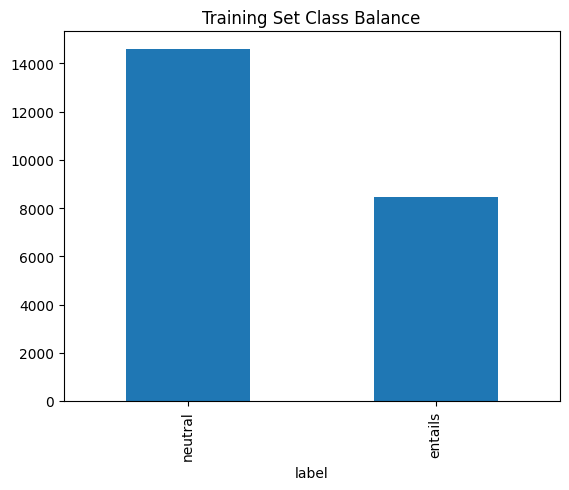

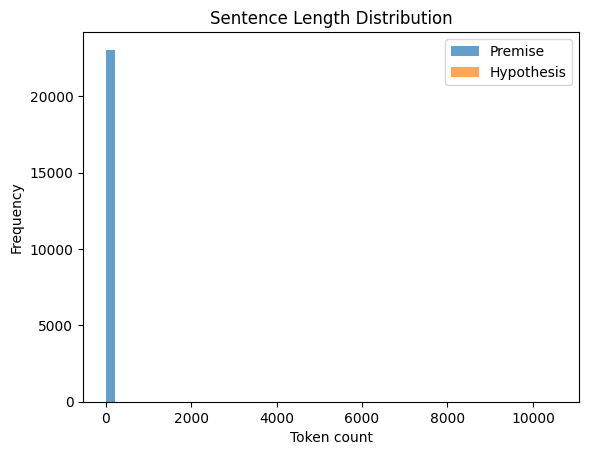

Average premise length: 18.01
Average hypothesis length: 11.74


In [95]:
from itertools import chain

# Step 1: Load datasets
def load_json_to_df(path):
    with open(path, "r") as f:
        data = json.load(f)
    return pd.DataFrame(data)

train_df = load_json_to_df(train_formatted_file)
val_df = load_json_to_df(validation_formatted_file)
test_df = load_json_to_df(test_formatted_file)

print("Train sample:")
print(train_df.head())

# Step 2: Clean and normalise text
def normalize_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z0-9\s]", "", text)  # remove punctuation
    text = re.sub(r"\s+", " ", text).strip()
    return text

for df in [train_df, val_df, test_df]:
    df.dropna(subset=["premise", "hypothesis", "label"], inplace=True)
    df.drop_duplicates(inplace=True)
    df["premise"] = df["premise"].apply(normalize_text)
    df["hypothesis"] = df["hypothesis"].apply(normalize_text)

# Step 3: Tokenise and lemmatise
lemmatizer = WordNetLemmatizer()

def tokenize_and_lemmatize(text):
    tokens = word_tokenize(text, language='english')
    lemmas = [lemmatizer.lemmatize(tok) for tok in tokens]
    return lemmas

for df in [train_df, val_df, test_df]:
    df["premise_tokens"] = df["premise"].apply(tokenize_and_lemmatize)
    df["hypothesis_tokens"] = df["hypothesis"].apply(tokenize_and_lemmatize)

print("\nTokenised example:")
print(train_df[["premise_tokens", "hypothesis_tokens"]].head(1))

#  Step 4: Encode labels
label_map = {"entails": 1, "neutral": 0}
for df in [train_df, val_df, test_df]:
    df["label_id"] = df["label"].map(label_map)

# Step 5: Vocabulary construction
all_tokens = list(chain.from_iterable(train_df["premise_tokens"])) + \
             list(chain.from_iterable(train_df["hypothesis_tokens"]))
vocab = sorted(set(all_tokens))
print(f"\nVocabulary size: {len(vocab)}")

# Build word→index mapping
word2idx = {word: idx + 1 for idx, word in enumerate(vocab)}  # +1 reserve 0 for padding
idx2word = {idx: word for word, idx in word2idx.items()}

# Step 6: Exploratory analysis
label_counts = train_df["label"].value_counts()
print("\nClass distribution (train):")
print(label_counts)

label_counts.plot(kind="bar", title="Training Set Class Balance")
plt.show()

premise_lens = train_df["premise_tokens"].apply(len)
hypothesis_lens = train_df["hypothesis_tokens"].apply(len)

plt.hist(premise_lens, bins=50, alpha=0.7, label="Premise")
plt.hist(hypothesis_lens, bins=50, alpha=0.7, label="Hypothesis")
plt.legend()
plt.title("Sentence Length Distribution")
plt.xlabel("Token count")
plt.ylabel("Frequency")
plt.show()

print(f"Average premise length: {premise_lens.mean():.2f}")
print(f"Average hypothesis length: {hypothesis_lens.mean():.2f}")


In [96]:
processed_files = ["train_preprocessed.csv", "val_preprocessed.csv", "test_preprocessed.csv"]

all_exist = all((sourceFolder /"data"/f).exists() for f in processed_files)
if all_exist:
  print("All processed files already exist. Using existing data.")
else:
  # Step 7: Save processed files
  train_df.to_csv(sourceFolder/"data/train_preprocessed.csv", index=False)
  val_df.to_csv(sourceFolder/"data/val_preprocessed.csv", index=False)
  test_df.to_csv(sourceFolder/"data/test_preprocessed.csv", index=False)
  print(f"\n Preprocessing complete. Cleaned datasets saved to {sourceFolder}/data/")

All processed files already exist. Using existing data.


# Creating Dataset

In [97]:
from collections import defaultdict
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import numpy as np

# Step 1: Build vocabulary from training data

all_tokens = [tok for toks in train_df["premise_tokens"] for tok in toks] + \
             [tok for toks in train_df["hypothesis_tokens"] for tok in toks]

vocab = {"<pad>": 0, "<unk>": 1}
for tok in all_tokens:
    if tok not in vocab:
        vocab[tok] = len(vocab)

inv_vocab = {i: w for w, i in vocab.items()}
print(f" Vocabulary built. Size: {len(vocab)}")

# Step 2: Token → Index conversion function
def encode_tokens(tokens, vocab):
    return [vocab.get(tok, vocab["<unk>"]) for tok in tokens]

train_df["premise_ids"] = train_df["premise_tokens"].apply(lambda x: encode_tokens(x, vocab))
train_df["hypothesis_ids"] = train_df["hypothesis_tokens"].apply(lambda x: encode_tokens(x, vocab))
val_df["premise_ids"] = val_df["premise_tokens"].apply(lambda x: encode_tokens(x, vocab))
val_df["hypothesis_ids"] = val_df["hypothesis_tokens"].apply(lambda x: encode_tokens(x, vocab))
test_df["premise_ids"] = test_df["premise_tokens"].apply(lambda x: encode_tokens(x, vocab))
test_df["hypothesis_ids"] = test_df["hypothesis_tokens"].apply(lambda x: encode_tokens(x, vocab))

print("Sample encoded example:")
print(train_df[["premise_ids", "hypothesis_ids"]].head(1))

# Step 3: Custom Dataset class for PyTorch
class NLIDataset(Dataset):
    def __init__(self, dataframe):
        self.premises = dataframe["premise_ids"].tolist()
        self.hypotheses = dataframe["hypothesis_ids"].tolist()
        self.labels = dataframe["label_id"].tolist()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        premise = torch.tensor(self.premises[idx], dtype=torch.long)
        hypothesis = torch.tensor(self.hypotheses[idx], dtype=torch.long)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return premise, hypothesis, label

# Step 4: Collate function for dynamic padding
def collate_fn(batch):
    premises, hypotheses, labels = zip(*batch)
    premises_padded = pad_sequence(premises, batch_first=True, padding_value=vocab["<pad>"])
    hypotheses_padded = pad_sequence(hypotheses, batch_first=True, padding_value=vocab["<pad>"])
    labels = torch.stack(labels)
    return premises_padded, hypotheses_padded, labels

# Step 5: Create DataLoaders
BATCH_SIZE = 32

train_dataset = NLIDataset(train_df)
val_dataset = NLIDataset(val_df)
test_dataset = NLIDataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

train_loader_16 = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
val_loader_16 = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)
test_loader_16 = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

print(f"DataLoaders ready. Train batches: {len(train_loader)}, Val batches: {len(val_loader)}")

# Step 6 (Optional): Quick sanity check
prem_batch, hyp_batch, lbl_batch = next(iter(train_loader))
print(f"\nPremise batch shape: {prem_batch.shape}")
print(f"Hypothesis batch shape: {hyp_batch.shape}")
print(f"Label batch shape: {lbl_batch.shape}")


 Vocabulary built. Size: 20118
Sample encoded example:
                        premise_ids                       hypothesis_ids
0  [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]  [10, 3, 5, 6, 7, 4, 47, 75, 57, 11]
DataLoaders ready. Train batches: 721, Val batches: 41

Premise batch shape: torch.Size([32, 44])
Hypothesis batch shape: torch.Size([32, 19])
Label batch shape: torch.Size([32])


- We are creating vocabulary for the words present in the hypothesis and premise.
- Each sentence gets converted into list of ids instead of words
- Creating a custom dataset class `NLIDataset` which tells pytorch how to read the one sample at one time
  - Premise -> list of token IDs
  - Hypothese -> list of token IDs
  - label -> integer label (0 or 1) based on the label_map
- `encode_tokens` is used to convert the list of words into list of work indexes
- Handle different sentence lengths by using padding.
  - collate_fn pads all sentences in a batch to the same length, it fills empty word spot with `<pad>` which has the id 0

- Create DataLoader
  - Batches data with 32 samples at a time
  - shuffles and uses collate_fn to each batch

In [98]:
# Sanity check to show one batch
prem_batch, hyp_batch, lbl_batch = next(iter(train_loader))
print(f"\nPremise batch shape: {prem_batch.shape}")
print(f"Hypothesis batch shape: {hyp_batch.shape}")
print(f"Label batch shape: {lbl_batch.shape}")
print(prem_batch[0])
print(hyp_batch[0])
print(lbl_batch[0])


Premise batch shape: torch.Size([32, 33])
Hypothesis batch shape: torch.Size([32, 19])
Label batch shape: torch.Size([32])
tensor([   94,  1017, 10822,   337,   692, 15784,    38,    34, 15785,  3082,
         5774,   136,  6443,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0])
tensor([   34,  3082,  5774,   136,  6443,    45,   511,    34,  1886,    19,
        10822,  6439,     0,     0,     0,     0,     0,     0,     0])
tensor(0)


In [99]:
# Encode tokens and labels
def encode_tokens(tokens, vocab):
    return [vocab.get(tok, vocab["<unk>"]) for tok in tokens]

for df in [train_df, val_df, test_df]:
    df["premise_ids"] = df["premise_tokens"].apply(lambda t: encode_tokens(t, vocab))
    df["hypothesis_ids"] = df["hypothesis_tokens"].apply(lambda t: encode_tokens(t, vocab))
    df["label_id"] = df["label"].map(label_map)   # keep consistent mapping

#  Save vocab and labels
import json, os
os.makedirs("utils", exist_ok=True)

with open(sourceFolder/"utils/vocab.json", "w") as f:
    json.dump(vocab, f)
with open(sourceFolder/"utils/labels.json", "w") as f:
    json.dump(label_map, f)

print(" Saved vocab and label maps to utils/")


#  Sanity check
prem, hyp, lbl = next(iter(train_loader))
print(f"Premise batch: {prem.shape}, Hypothesis batch: {hyp.shape}, Labels: {lbl.shape}")


 Saved vocab and label maps to utils/
Premise batch: torch.Size([32, 35]), Hypothesis batch: torch.Size([32, 20]), Labels: torch.Size([32])


In [100]:
prem, hyp, lbl = next(iter(train_loader_16))
print(f"Premise batch: {prem.shape}, Hypothesis batch: {hyp.shape}, Labels: {lbl.shape}")

Premise batch: torch.Size([16, 42]), Hypothesis batch: torch.Size([16, 24]), Labels: torch.Size([16])


Printing label map again

In [101]:
label_map

{'entails': 1, 'neutral': 0}

## Model Preparation


In [102]:
import torch, torch.nn as nn, torch.nn.functional as F
import math

In [103]:
import torch, random, numpy as np

SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


# Model 1: BiLSTM

## Setting up the embeddings

In [104]:
import numpy as np
import torch.nn as nn

EMB_DIM = 100  # 50, 100, or 300 depending on GloVe file used
GLOVE_PATH = sourceFolder/"glove/glove.6B.100d.txt"


# 1. Load glove vectors
glove_vectors = {}
with open(GLOVE_PATH, "r", encoding="utf8") as f:
    for line in f:
        parts = line.strip().split()
        word = parts[0]
        vector = np.array(parts[1:], dtype=np.float32)
        glove_vectors[word] = vector

print(f"Loaded {len(glove_vectors):,} GloVe word vectors.")

# 2. Build embedding matrix for modifed vocab
embedding_matrix = np.zeros((len(vocab), EMB_DIM), dtype=np.float32)

for word, idx in vocab.items():
    if word in glove_vectors:
        embedding_matrix[idx] = glove_vectors[word]
    else:
        embedding_matrix[idx] = np.random.normal(scale=0.6, size=(EMB_DIM,))

embedding_matrix = torch.tensor(embedding_matrix)
print(f" Embedding matrix shape: {embedding_matrix.shape}")


Loaded 400,000 GloVe word vectors.
 Embedding matrix shape: torch.Size([20118, 100])


In [105]:
embedding_layer = nn.Embedding.from_pretrained(
    embedding_matrix,
    freeze=False,            # False = fine-tune embeddings during training
    padding_idx=vocab["<pad>"]
)

print("Embedding layer ready.")


Embedding layer ready.


In [106]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

criterion = nn.CrossEntropyLoss()
def accuracy(preds, labels):
    _, predicted = torch.max(preds, 1)
    return (predicted == labels).float().mean()

Using device: cuda


In [107]:
for name, df in zip(["train", "val", "test"], [train_df, val_df, test_df]):
    print(name, "labels:", df["label_id"].unique())


train labels: [0 1]
val labels: [0 1]
test labels: [0 1]


In [108]:
# BiLSTM Baseline Model (Model 1)

import torch
import torch.nn as nn
from torch.optim import Adam
from tqdm import tqdm
import zipfile
import os

# Step 1: Model Definition
class BiLSTMBase(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, num_classes, pad_idx, dropout=0.3):
        super().__init__()
        num_embeddings, embed_dim = embedding_matrix.size()

        # Pretrained embedding layer (GloVe)
        self.embedding = nn.Embedding.from_pretrained(
            embedding_matrix, freeze=False, padding_idx=pad_idx
        )

        self.bilstm = nn.LSTM(embed_dim, hidden_dim,
                              batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout)
        self.pool = nn.AdaptiveMaxPool1d(1)   # variable-length seq → fixed vector
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim * 2 * 3, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_classes)
        )

    def encode(self, x):
        emb = self.embedding(x)               # (B, L, E)
        out, _ = self.bilstm(emb)             # (B, L, 2H)
        out = out.permute(0, 2, 1)            # (B, 2H, L)
        pooled = self.pool(out).squeeze(-1)   # (B, 2H)
        return self.dropout(pooled)

    def forward(self, premise, hypothesis):
        p_vec = self.encode(premise)
        h_vec = self.encode(hypothesis)
        combined = torch.cat([p_vec, h_vec, torch.abs(p_vec - h_vec)], dim=1)
        logits = self.fc(combined)
        return logits


In [109]:
#  Step 2: Initialise Model
vocab_size = len(vocab)
hidden_dim = 128
num_classes = 2
pad_idx = vocab["<pad>"]

model1_BiLSTMBase = BiLSTMBase(embedding_matrix, hidden_dim, num_classes, pad_idx).to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model1_BiLSTMBase.parameters(), lr=1e-3)
epochs = 5

In [110]:
# For logging
train_losses, val_losses = [], []
train_accs, val_accs = [], []

# Step 3: Training + Validation Loop
for epoch in range(epochs):
    model1_BiLSTMBase.train()
    train_loss, train_correct, train_total = 0, 0, 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")

    for premises, hypotheses, labels in loop:
        premises, hypotheses, labels = premises.to(DEVICE), hypotheses.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        logits = model1_BiLSTMBase(premises, hypotheses)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        preds = torch.argmax(logits, dim=1)
        train_loss += loss.item() * labels.size(0)
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)

        loop.set_postfix(loss=train_loss/train_total, acc=train_correct/train_total)

    # Validation
    model1_BiLSTMBase.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for premises, hypotheses, labels in val_loader:
            premises, hypotheses, labels = premises.to(DEVICE), hypotheses.to(DEVICE), labels.to(DEVICE)
            logits = model1_BiLSTMBase(premises, hypotheses)
            loss = criterion(logits, labels)
            preds = torch.argmax(logits, dim=1)

            val_loss += loss.item() * labels.size(0)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    print(f"Epoch {epoch+1}: "
          f"Train Loss={train_loss/train_total:.4f}, Train Acc={train_correct/train_total:.4f}, "
          f"Val Loss={val_loss/val_total:.4f}, Val Acc={val_correct/val_total:.4f}")
    train_losses.append(train_loss / train_total)
    train_accs.append(train_correct / train_total)
    val_losses.append(val_loss / val_total)
    val_accs.append(val_correct / val_total)

Epoch 1/5: 100%|██████████| 721/721 [00:06<00:00, 106.40it/s, acc=0.765, loss=0.478]


Epoch 1: Train Loss=0.4780, Train Acc=0.7647, Val Loss=0.6921, Val Acc=0.6449


Epoch 2/5: 100%|██████████| 721/721 [00:06<00:00, 106.08it/s, acc=0.867, loss=0.311]


Epoch 2: Train Loss=0.3106, Train Acc=0.8673, Val Loss=0.7694, Val Acc=0.6825


Epoch 3/5: 100%|██████████| 721/721 [00:06<00:00, 107.19it/s, acc=0.907, loss=0.229]


Epoch 3: Train Loss=0.2287, Train Acc=0.9072, Val Loss=0.6388, Val Acc=0.7416


Epoch 4/5: 100%|██████████| 721/721 [00:06<00:00, 106.97it/s, acc=0.935, loss=0.165]


Epoch 4: Train Loss=0.1646, Train Acc=0.9354, Val Loss=0.8197, Val Acc=0.7232


Epoch 5/5: 100%|██████████| 721/721 [00:06<00:00, 108.17it/s, acc=0.951, loss=0.124]


Epoch 5: Train Loss=0.1245, Train Acc=0.9512, Val Loss=0.7146, Val Acc=0.7592


In [111]:
# Step 4: Save Model Weights
model_path_BiLSTM_Baseline = sourceFolder/"models/bilstm_baseline.pt"
torch.save(model1_BiLSTMBase.state_dict(), model_path_BiLSTM_Baseline)
print(f"Model saved to {model_path_BiLSTM_Baseline}")

# Step 5: Create Zip for Download
zip_path = sourceFolder/"models/bilstm_baseline.zip"
with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
    zipf.write(model_path_BiLSTM_Baseline, arcname=os.path.basename(model_path_BiLSTM_Baseline))

print(f" Model zipped and ready for download: {zip_path}")

Model saved to /content/drive/MyDrive/nlp_grp/NLP Group Assignment (Group 18)/models/bilstm_baseline.pt
 Model zipped and ready for download: /content/drive/MyDrive/nlp_grp/NLP Group Assignment (Group 18)/models/bilstm_baseline.zip


In [ ]:
#Step 6: Make Downloadable (Colab)
## UNCOMMENT TO DOWNLOAD
# from google.colab import files
# files.download(zip_path)

## Visualisation

### Model Evaluation

In [112]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Evaluation helper
def evaluate_model(model, loader, device):
    model.eval()
    preds, labels_all = [], []
    with torch.no_grad():
        for premises, hypotheses, labels in loader:
            premises, hypotheses, labels = premises.to(device), hypotheses.to(device), labels.to(device)

            outputs = model(premises, hypotheses)
            logits = outputs[0] if isinstance(outputs, tuple) else outputs  # handle (logits, attn)

            pred = torch.argmax(logits, dim=1)
            preds.extend(pred.cpu().numpy())
            labels_all.extend(labels.cpu().numpy())
    return preds, labels_all

def evaluate_loss(model, loader, device):
    model.eval()
    total_loss = 0.0
    total_samples = 0
    criterion = torch.nn.CrossEntropyLoss()
    with torch.no_grad():
        for premises, hypotheses, labels in loader:
            premises, hypotheses, labels = premises.to(device), hypotheses.to(device), labels.to(device)

            outputs = model(premises, hypotheses)
            # handle tuple outputs (e.g., logits, attn)
            logits = outputs[0] if isinstance(outputs, tuple) else outputs

            loss = criterion(logits, labels)
            total_loss += loss.item() * labels.size(0)
            total_samples += labels.size(0)
    return total_loss / total_samples

# Validation metrics
val_preds, val_labels = evaluate_model(model1_BiLSTMBase, val_loader, DEVICE)
print("Validation Classification Report:")
print(classification_report(val_labels, val_preds, target_names=["neutral", "entails"]))

# Test metrics
test_preds, test_labels = evaluate_model(model1_BiLSTMBase, test_loader, DEVICE)
print("Test Classification Report:")
print(classification_report(test_labels, test_preds, target_names=["neutral", "entails"]))


Validation Classification Report:
              precision    recall  f1-score   support

     neutral       0.88      0.59      0.71       647
     entails       0.70      0.92      0.79       657

    accuracy                           0.76      1304
   macro avg       0.79      0.76      0.75      1304
weighted avg       0.79      0.76      0.75      1304

Test Classification Report:
              precision    recall  f1-score   support

     neutral       0.86      0.61      0.72      1284
     entails       0.59      0.84      0.69       842

    accuracy                           0.71      2126
   macro avg       0.72      0.73      0.71      2126
weighted avg       0.75      0.71      0.71      2126



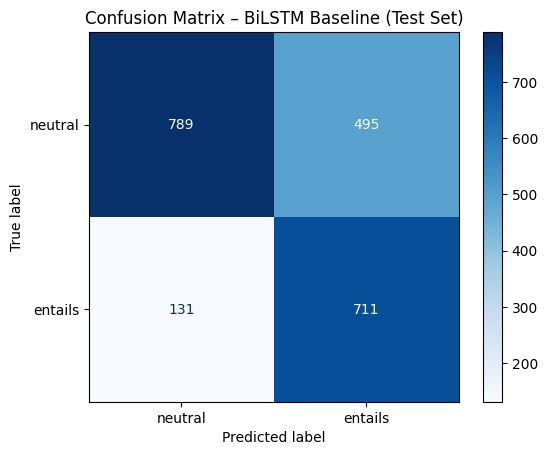

In [113]:
cm = confusion_matrix(test_labels, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["neutral", "entails"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix – BiLSTM Baseline (Test Set)")
plt.show()


Final Test Loss: 0.8585


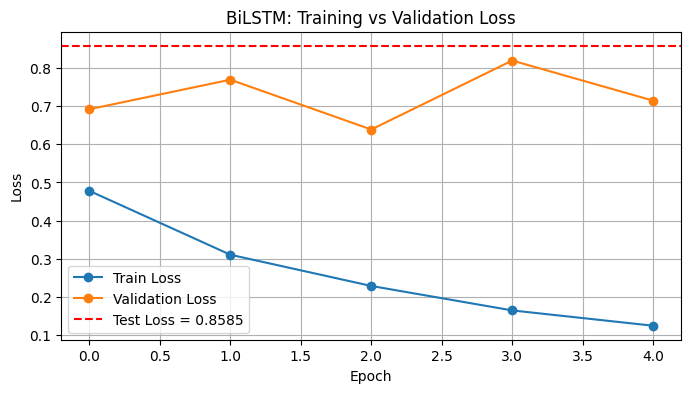

Final Test Accuracy: 0.7056


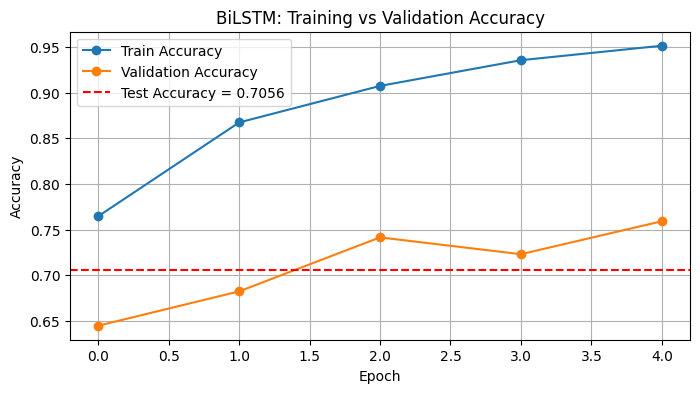

In [114]:
# Compute test loss
test_loss = evaluate_loss(model1_BiLSTMBase, test_loader, DEVICE)
print(f"Final Test Loss: {test_loss:.4f}")

# --- Plot Loss Curves ---
plt.figure(figsize=(8,4))
plt.plot(train_losses, label="Train Loss", marker='o')
plt.plot(val_losses, label="Validation Loss", marker='o')
plt.axhline(y=test_loss, color='red', linestyle='--', label=f"Test Loss = {test_loss:.4f}")
plt.legend()
plt.legend()
plt.title("BiLSTM: Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


# Compute test accuracy
test_preds, test_labels = evaluate_model(model1_BiLSTMBase, test_loader, DEVICE)
test_acc = accuracy_score(test_labels, test_preds)
print(f"Final Test Accuracy: {test_acc:.4f}")

# --- Plot Accuracy Curves ---
plt.figure(figsize=(8,4))
plt.plot(train_accs, label="Train Accuracy", marker='o')
plt.plot(val_accs, label="Validation Accuracy", marker='o')
plt.axhline(y=test_acc, color='red', linestyle='--', label=f"Test Accuracy = {test_acc:.4f}")
plt.legend()
plt.title("BiLSTM: Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()



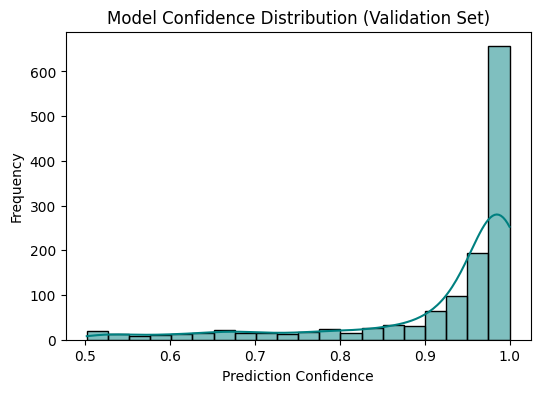

In [115]:
import torch.nn.functional as F
import seaborn as sns

# Collect model confidences on validation set
model1_BiLSTMBase.eval()
confidences = []
with torch.no_grad():
    for premises, hypotheses, labels in val_loader:
        premises, hypotheses = premises.to(DEVICE), hypotheses.to(DEVICE)
        logits = model1_BiLSTMBase(premises, hypotheses)
        probs = F.softmax(logits, dim=1)
        confidences.extend(probs.max(dim=1)[0].cpu().numpy())

plt.figure(figsize=(6,4))
sns.histplot(confidences, bins=20, kde=True, color="teal")
plt.title("Model Confidence Distribution (Validation Set)")
plt.xlabel("Prediction Confidence")
plt.ylabel("Frequency")
plt.show()


In [116]:
plt.savefig(sourceFolder/"results/bilstm_loss_curve.png", dpi=300)
plt.savefig(sourceFolder/"results/bilstm_accuracy_curve.png", dpi=300)
plt.savefig(sourceFolder/"results/bilstm_confidence_hist.png", dpi=300)


<Figure size 640x480 with 0 Axes>

### Cleanup

In [117]:
import gc, torch
gc.collect()
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()


# Model 2: BiLSTM with cross attention

In [118]:
import numpy as np
import torch.nn as nn

EMB_DIM = 100  # 50, 100, or 300 depending on GloVe file used
GLOVE_PATH = sourceFolder/"glove/glove.6B.100d.txt"


# 1. Load glove vectors
glove_vectors = {}
with open(GLOVE_PATH, "r", encoding="utf8") as f:
    for line in f:
        parts = line.strip().split()
        word = parts[0]
        vector = np.array(parts[1:], dtype=np.float32)
        glove_vectors[word] = vector

print(f"Loaded {len(glove_vectors):,} GloVe word vectors.")

# 2. Build embedding matrix for modifed vocab
embedding_matrix = np.zeros((len(vocab), EMB_DIM), dtype=np.float32)

for word, idx in vocab.items():
    if word in glove_vectors:
        embedding_matrix[idx] = glove_vectors[word]
    else:
        embedding_matrix[idx] = np.random.normal(scale=0.6, size=(EMB_DIM,))

embedding_matrix = torch.tensor(embedding_matrix)
print(f" Embedding matrix shape: {embedding_matrix.shape}")


Loaded 400,000 GloVe word vectors.
 Embedding matrix shape: torch.Size([20118, 100])


In [119]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

criterion = nn.CrossEntropyLoss()
def accuracy(preds, labels):
    _, predicted = torch.max(preds, 1)
    return (predicted == labels).float().mean()


Using device: cuda


In [120]:
for name, df in zip(["train", "val", "test"], [train_df, val_df, test_df]):
    print(name, "labels:", df["label_id"].unique())


train labels: [0 1]
val labels: [0 1]
test labels: [0 1]


## Architecture
This model extends the baseline BiLSTM + Pooling by introducing *cross-attention* between the premise and the hypothesis.  
Instead of treating both sentences independently, the hypothesis learns to attend to informative tokens in the premise, enabling word-level alignment for Natural Language Inference.


In [121]:
import gc, torch
gc.collect()
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()

### Cross-Attention Explanation
For each word in the hypothesis (`Q`), we compute similarity with every word in the premise (`K`).  
The softmax-normalised weights form an alignment matrix `α`, which is used to build a weighted context vector `C = α × V`.  
Thus each hypothesis token receives a contextualised representation of the premise.


In [122]:
class CrossAttention(nn.Module):
    """
    Cross-Attention: lets the hypothesis attend to the premise.
    premise_enc: (B, Lp, D)
    hypo_enc:    (B, Lh, D)
    """
    def __init__(self, hidden_dim, dropout=0.1):
        super().__init__()
        self.scale = hidden_dim ** -0.5
        self.dropout = nn.Dropout(dropout)
        self.Wq = nn.Linear(hidden_dim, hidden_dim, bias=False)
        self.Wk = nn.Linear(hidden_dim, hidden_dim, bias=False)
        self.Wv = nn.Linear(hidden_dim, hidden_dim, bias=False)

    def forward(self, premise_enc, hypo_enc, mask=None):
        Q = self.Wq(hypo_enc)                     # (B, Lh, D)
        K = self.Wk(premise_enc)                  # (B, Lp, D)
        V = self.Wv(premise_enc)                  # (B, Lp, D)

        # scaled dot-product attention
        attn_logits = torch.matmul(Q, K.transpose(1, 2)) * self.scale  # (B, Lh, Lp)
        if mask is not None:
            attn_logits = attn_logits.masked_fill(mask == 0, -1e9)
        attn_weights = F.softmax(attn_logits, dim=-1)                  # (B, Lh, Lp)
        attn_weights = self.dropout(attn_weights)
        context = torch.matmul(attn_weights, V)                        # (B, Lh, D)
        return context, attn_weights


### Model Forward Flow
1. Encode premise and hypothesis separately with BiLSTMs.  
2. Compute cross-attention (`hypothesis → premise`).  
3. Pool both the hypothesis encoding and its attended context.  
4. Concatenate `[H, C, |H−C|, H⊙C]` and classify via MLP.


In [123]:
class BiLSTMCrossAttention(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim=128, num_classes=2, dropout=0.3):
        super().__init__()
        num_embeddings, embed_dim = embedding_matrix.size()
        self.embedding = nn.Embedding.from_pretrained(
            embedding_matrix, freeze=False, padding_idx=vocab["<pad>"]
        )
        self.bilstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.cross_attn = CrossAttention(hidden_dim*2, dropout=dropout)
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(hidden_dim*8, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def encode(self, x):
        H, _ = self.bilstm(self.embedding(x))       # (B, L, 2H)
        return H

    def forward(self, premise, hypothesis):
        P = self.encode(premise)                    # (B, Lp, 2H)
        H = self.encode(hypothesis)                 # (B, Lh, 2H)
        C, attn = self.cross_attn(P, H)             # (B, Lh, 2H)
        # Pool along sequence dimension
        H_pool = self.pool(H.transpose(1, 2)).squeeze(-1)
        C_pool = self.pool(C.transpose(1, 2)).squeeze(-1)
        diff = torch.abs(H_pool - C_pool)
        prod = H_pool * C_pool
        combined = torch.cat([H_pool, C_pool, diff, prod], dim=1)
        logits = self.fc(combined)
        return logits, attn


In [124]:
model2 = BiLSTMCrossAttention(embedding_matrix, hidden_dim=128).to(DEVICE)
prem, hyp, lbl = next(iter(train_loader))
prem, hyp = prem.to(DEVICE), hyp.to(DEVICE)
with torch.no_grad():
    logits, attn = model2(prem, hyp)
print("logits:", logits.shape, "attention:", attn.shape)


logits: torch.Size([32, 2]) attention: torch.Size([32, 21, 35])


We verify that the model outputs:
- `logits`: (batch, num_classes)  
- `attention`: (batch, len_hypothesis, len_premise) — for later heat-map visualisation.


In [125]:
logits, _ = model2(prem, hyp)

In [126]:
prem, hyp, lbl = next(iter(train_loader))
prem, hyp = prem.to(DEVICE), hyp.to(DEVICE)
with torch.no_grad():
    logits, attn = model2(prem, hyp)
print("✓ Forward pass OK:", logits.shape, attn.shape)


✓ Forward pass OK: torch.Size([32, 2]) torch.Size([32, 27, 43])


### Cross-Attention Heatmap
Rows = hypothesis tokens.  
Columns = premise tokens.  
Brighter cells indicate stronger attention weights—i.e., which premise words each hypothesis word relied on for entailment reasoning.


In [127]:
def visualize_cross_attention(model, premise, hypothesis, vocab):
    model.eval()
    prem_tokens = re.sub(r"[^a-z0-9\s]", "", premise.lower()).split()
    hyp_tokens  = re.sub(r"[^a-z0-9\s]", "", hypothesis.lower()).split()
    prem_ids = torch.tensor([[vocab.get(t, vocab["<unk>"]) for t in prem_tokens]]).to(DEVICE)
    hyp_ids  = torch.tensor([[vocab.get(t, vocab["<unk>"]) for t in hyp_tokens]]).to(DEVICE)
    with torch.no_grad():
        _, attn = model(prem_ids, hyp_ids)
    attn = attn.squeeze(0).cpu().numpy()
    plt.figure(figsize=(8,6))
    sns.heatmap(attn, xticklabels=prem_tokens, yticklabels=hyp_tokens, cmap="YlGnBu")
    plt.xlabel("Premise words"); plt.ylabel("Hypothesis words")
    plt.title("Cross-Attention Heatmap (Hypothesis → Premise)")
    plt.show()


### Training and Validation Loop  
We reuse the same optimisation pipeline as the previous model but adapt it for the new output signature:  
`logits, attn = model2(premise, hypothesis)`.  
Only the logits are used for loss and accuracy; the attention matrix is saved later for visualisation.


In [149]:
# Training + Validation for BiLSTM + Cross-Attention

model2 = BiLSTMCrossAttention(embedding_matrix, hidden_dim=128).to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=1e-3)
scaler = torch.cuda.amp.GradScaler()

EPOCHS = 5
train_losses, val_losses, train_accs, val_accs = [], [], [], []
best_val_acc = 0.0

def accuracy(preds, labels):
    return (preds.argmax(1) == labels).float().mean().item()

for epoch in range(EPOCHS):
    print(f"\n===== Epoch {epoch+1}/{EPOCHS} =====")
    # --------------------- TRAIN ---------------------
    model2.train()
    total_loss, total_acc, total_samples = 0, 0, 0
    for prem, hyp, lbl in tqdm(train_loader, desc="Training", leave=False):
        prem, hyp, lbl = prem.to(DEVICE), hyp.to(DEVICE), lbl.to(DEVICE)
        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast():
            logits, _ = model2(prem, hyp)
            loss = criterion(logits, lbl)
        # Gradient clipping to stabilise training
        torch.nn.utils.clip_grad_norm_(model2.parameters(), max_norm=5)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        total_acc += accuracy(logits, lbl) * lbl.size(0)
        total_samples += lbl.size(0)

    train_loss = total_loss / len(train_loader)
    train_acc = total_acc / total_samples
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # --------------------- VALIDATE ---------------------
    model2.eval()
    val_loss, val_acc, val_samples = 0, 0, 0
    with torch.no_grad(), torch.cuda.amp.autocast():
        for prem, hyp, lbl in tqdm(val_loader, desc="Validation", leave=False):
            prem, hyp, lbl = prem.to(DEVICE), hyp.to(DEVICE), lbl.to(DEVICE)
            logits, _ = model2(prem, hyp)
            loss = criterion(logits, lbl)
            val_loss += loss.item()
            val_acc += accuracy(logits, lbl) * lbl.size(0)
            val_samples += lbl.size(0)
    val_loss /= len(val_loader)
    val_acc /= val_samples
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Train Loss={train_loss:.4f} Acc={train_acc:.3f} | Val Loss={val_loss:.4f} Acc={val_acc:.3f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model2.state_dict(), sourceFolder/"models/bilstm_crossattn_best.pt")
        print(f"Saved new best model (Val Acc = {val_acc:.3f})")

torch.save(model2.state_dict(), sourceFolder/"models/bilstm_crossattn_last.pt")
print(f"\nTraining complete. Best Val Acc = {best_val_acc:.3f}")


/tmp/ipython-input-519477420.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()



===== Epoch 1/5 =====


Training:   0%|          | 0/721 [00:00<?, ?it/s]/tmp/ipython-input-519477420.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-519477420.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast():


Train Loss=0.5021 Acc=0.751 | Val Loss=0.5928 Acc=0.673
Saved new best model (Val Acc = 0.673)

===== Epoch 2/5 =====


Train Loss=0.3317 Acc=0.856 | Val Loss=0.6077 Acc=0.691
Saved new best model (Val Acc = 0.691)

===== Epoch 3/5 =====


Train Loss=0.2310 Acc=0.904 | Val Loss=0.6482 Acc=0.722
Saved new best model (Val Acc = 0.722)

===== Epoch 4/5 =====


Train Loss=0.1576 Acc=0.936 | Val Loss=0.7372 Acc=0.728
Saved new best model (Val Acc = 0.728)

===== Epoch 5/5 =====


Train Loss=0.1039 Acc=0.959 | Val Loss=0.9781 Acc=0.722

Training complete. Best Val Acc = 0.728


## Export

In [150]:
# Step 4: Save Model Weights
model_path_BiLSTM_CrossAttention = sourceFolder/"models/bilstm_crossattn_last.pt"
torch.save(model2.state_dict(), model_path_BiLSTM_CrossAttention)
print(f"Model saved to {model_path_BiLSTM_CrossAttention}")

# Step 5: Create Zip for Download
zip_path = sourceFolder/"models/bilstm_crossattn_last.zip"
with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
    zipf.write(model_path_BiLSTM_CrossAttention, arcname=os.path.basename(model_path_BiLSTM_CrossAttention))

print(f" Model zipped and ready for download: {zip_path}")

Model saved to /content/drive/MyDrive/nlp_grp/NLP Group Assignment (Group 18)/models/bilstm_crossattn_last.pt
 Model zipped and ready for download: /content/drive/MyDrive/nlp_grp/NLP Group Assignment (Group 18)/models/bilstm_crossattn_last.zip


In [ ]:
# import zipfile
# best_path = "models/bilstm_crossattn_best.pt"
# zip_path  = "models/bilstm_crossattn_best.zip"
# with zipfile.ZipFile(zip_path, "w", zipfile.ZIP_DEFLATED) as zipf:
#     zipf.write(best_path, arcname=os.path.basename(best_path))
# print(f" Best model zipped for download → {zip_path}")


## Visualisation

### Training Curves  
Visualising loss and accuracy across epochs helps detect overfitting or underfitting.

Final Test Loss: 1.1873


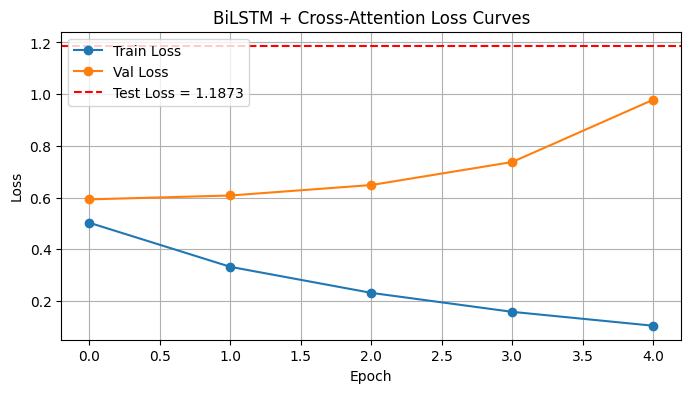

Final Test Accuracy: 0.7093


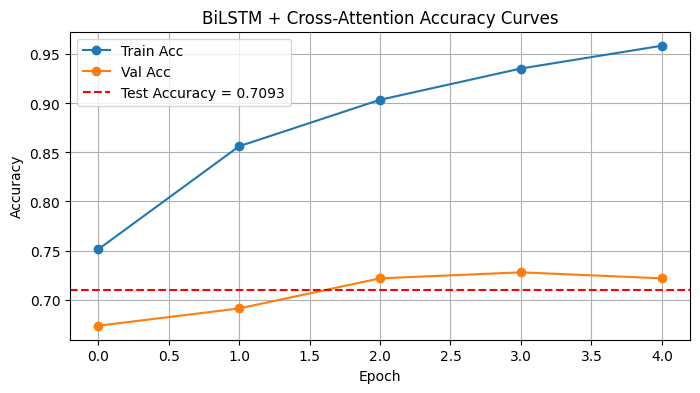

In [151]:
# --- Compute Test Loss ---
test_loss = evaluate_loss(model2, test_loader, DEVICE)
print(f"Final Test Loss: {test_loss:.4f}")

# --- Plot Loss --
plt.figure(figsize=(8,4))
plt.plot(train_losses, label="Train Loss", marker="o")
plt.plot(val_losses, label="Val Loss", marker="o")
plt.axhline(test_loss, color='red', linestyle='--', label=f"Test Loss = {test_loss:.4f}")
plt.legend(); plt.title("BiLSTM + Cross-Attention Loss Curves")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.grid(True)
plt.show()

# --- Compute Test Accuracy ---
test_preds, test_labels = evaluate_model(model2, test_loader, DEVICE)
from sklearn.metrics import accuracy_score
test_acc = accuracy_score(test_labels, test_preds)
print(f"Final Test Accuracy: {test_acc:.4f}")

# --- Plot Accuracy ---
plt.figure(figsize=(8,4))
plt.plot(train_accs, label="Train Acc", marker="o")
plt.plot(val_accs, label="Val Acc", marker="o")
plt.axhline(test_acc, color='red', linestyle='--', label=f"Test Accuracy = {test_acc:.4f}")
plt.legend(); plt.title("BiLSTM + Cross-Attention Accuracy Curves")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.grid(True)
plt.show()


### Evaluation and Classification Reports  
We evaluate the best checkpoint on validation and test sets and produce confusion matrices and metrics.



Validation Classification Report:
              precision    recall  f1-score   support

     neutral       0.69      0.79      0.74       647
     entails       0.76      0.65      0.70       657

    accuracy                           0.72      1304
   macro avg       0.73      0.72      0.72      1304
weighted avg       0.73      0.72      0.72      1304



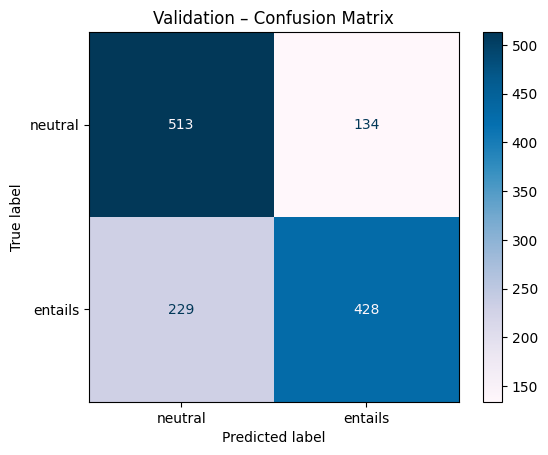


Test Classification Report:
              precision    recall  f1-score   support

     neutral       0.74      0.79      0.77      1284
     entails       0.65      0.58      0.61       842

    accuracy                           0.71      2126
   macro avg       0.70      0.69      0.69      2126
weighted avg       0.71      0.71      0.71      2126



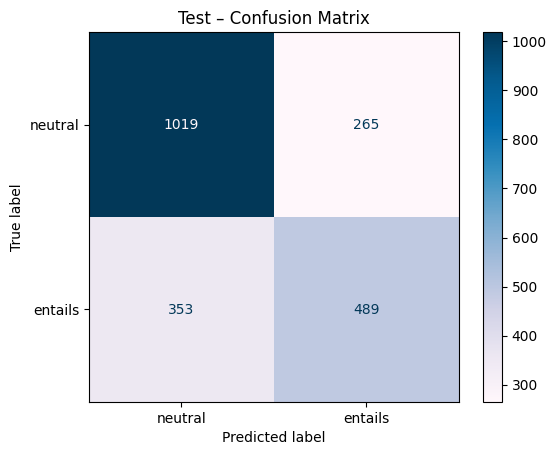

In [152]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

def evaluate_model(model, loader, device):
    model.eval()
    preds, labels_all = [], []
    with torch.no_grad():
        for prem, hyp, lbl in loader:
            prem, hyp, lbl = prem.to(device), hyp.to(device), lbl.to(device)

            outputs = model(prem, hyp)
            # handle models that return tuples (logits, attention, etc.)
            logits = outputs[0] if isinstance(outputs, tuple) else outputs

            pred = torch.argmax(logits, dim=1)
            preds.extend(pred.cpu().numpy())
            labels_all.extend(lbl.cpu().numpy())

    return np.array(preds), np.array(labels_all)

# Load best checkpoint
best_model_path = sourceFolder/"models/bilstm_crossattn_last.pt"
model2.load_state_dict(torch.load(best_model_path))

for name, loader in [("Validation", val_loader), ("Test", test_loader)]:
    preds, labels = evaluate_model(model2, loader, DEVICE)
    print(f"\n{name} Classification Report:")
    print(classification_report(labels, preds, target_names=["neutral","entails"]))
    cm = confusion_matrix(labels, preds)
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["neutral","entails"]).plot(cmap="PuBu")
    plt.title(f"{name} – Confusion Matrix")
    plt.show()


## Attention Visualisation

The cross-attention matrix (len_hypothesis × len_premise) shows which premise tokens each hypothesis token focused on.
We use a heatmap to interpret the model’s reasoning.

# Ablation for Model 2: BiLSTM with global query attention

In [153]:
import gc, torch
gc.collect()
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()


In [154]:
import torch, torch.nn as nn, torch.nn.functional as F
import math, os, zipfile, re
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [155]:
MAX_LEN = 80        # Cap sequence length (based on histograms)
BATCH_SIZE = 16     # Half previous batch size

### Global Query Attention

In [156]:
class GlobalQueryAttention(nn.Module):
    """Single-query scaled dot-product attention"""
    def __init__(self, d_model, d_k, dropout=0.1):
        super().__init__()
        self.q_proj = nn.Linear(d_model, d_k, bias=False)
        self.k_proj = nn.Linear(d_model, d_k, bias=False)
        self.v_proj = nn.Linear(d_model, d_k, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, H):
        # H: (B, T, D)
        Q = self.q_proj(H.mean(dim=1, keepdim=True))  # (B,1,d_k)
        K = self.k_proj(H)                            # (B,T,d_k)
        V = self.v_proj(H)                            # (B,T,d_k)
        attn_logits = torch.matmul(Q, K.transpose(-2, -1)).squeeze(1) / math.sqrt(K.size(-1))  # (B,T)
        weights = torch.softmax(attn_logits, dim=-1)
        weights = self.dropout(weights)
        context = torch.matmul(weights.unsqueeze(1), V).squeeze(1)  # (B,d_k)
        return context, weights

### BiLSTM with Global Attention Module

In [157]:
class BiLSTMGlobalAttn(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim=128, d_k=64, num_classes=2, dropout=0.3):
        super().__init__()
        num_embeddings, embed_dim = embedding_matrix.size()
        self.embedding = nn.Embedding.from_pretrained(
            embedding_matrix, freeze=False, padding_idx=vocab["<pad>"]
        )
        self.bilstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.attn = GlobalQueryAttention(d_model=hidden_dim*2, d_k=d_k)
        self.fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(d_k*3, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def encode(self, x):
        H, _ = self.bilstm(self.embedding(x))
        ctx, _ = self.attn(H)
        return ctx

    def forward(self, premise, hypothesis):
        p_vec = self.encode(premise)
        h_vec = self.encode(hypothesis)
        combined = torch.cat([p_vec, h_vec, torch.abs(p_vec - h_vec)], dim=1)
        return self.fc(combined)

In [158]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2_BiLSTM_GlobAttn = BiLSTMGlobalAttn(embedding_matrix, hidden_dim=128, d_k=64).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2_BiLSTM_GlobAttn.parameters(), lr=1e-3)
scaler = torch.cuda.amp.GradScaler()
epochs = 5
train_losses, val_losses, train_accs, val_accs = [], [], [], []
best_val_acc = 0.0

/tmp/ipython-input-3065746216.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [159]:
for epoch in range(epochs):
    print(f"\n===== Epoch {epoch+1}/{epochs} =====")
    model2_BiLSTM_GlobAttn.train()
    total_loss, correct, total = 0, 0, 0
    for prem, hyp, lbl in tqdm(train_loader, desc="Training", leave=False):
        prem, hyp, lbl = prem.to(DEVICE), hyp.to(DEVICE), lbl.to(DEVICE)
        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast():
            logits = model2_BiLSTM_GlobAttn(prem, hyp)
            loss = criterion(logits, lbl)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        correct += (preds == lbl).sum().item()
        total += lbl.size(0)

    train_loss, train_acc = total_loss/len(train_loader), correct/total
    train_losses.append(train_loss); train_accs.append(train_acc)

    # --- Validation ---
    model2_BiLSTM_GlobAttn.eval(); vloss, vcorrect, vtotal = 0, 0, 0
    with torch.no_grad(), torch.cuda.amp.autocast():
        for prem, hyp, lbl in tqdm(val_loader, desc="Validation", leave=False):
            prem, hyp, lbl = prem.to(DEVICE), hyp.to(DEVICE), lbl.to(DEVICE)
            logits = model2_BiLSTM_GlobAttn(prem, hyp)
            loss = criterion(logits, lbl)
            preds = torch.argmax(logits, dim=1)
            vloss += loss.item()
            vcorrect += (preds == lbl).sum().item()
            vtotal += lbl.size(0)
    val_loss, val_acc = vloss/len(val_loader), vcorrect/vtotal
    val_losses.append(val_loss); val_accs.append(val_acc)
    print(f"Train Loss={train_loss:.4f} Acc={train_acc:.3f} | Val Loss={val_loss:.4f} Acc={val_acc:.3f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model2_BiLSTM_GlobAttn.state_dict(), sourceFolder/"models/bilstm_globalattn_best.pt")
        print(f"New best model saved (Val Acc = {val_acc:.3f})")

torch.save(model2_BiLSTM_GlobAttn.state_dict(), sourceFolder/"models/bilstm_globalattn_last.pt")
print(f"\nTraining done. Best Val Acc = {best_val_acc:.3f}")


===== Epoch 1/5 =====


Training:   0%|          | 0/721 [00:00<?, ?it/s]/tmp/ipython-input-1926467364.py:8: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-1926467364.py:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast():


Train Loss=0.5324 Acc=0.722 | Val Loss=0.5343 Acc=0.734
New best model saved (Val Acc = 0.734)

===== Epoch 2/5 =====


Train Loss=0.3510 Acc=0.847 | Val Loss=0.5667 Acc=0.716

===== Epoch 3/5 =====


Train Loss=0.2417 Acc=0.900 | Val Loss=0.7270 Acc=0.712

===== Epoch 4/5 =====


Train Loss=0.1696 Acc=0.931 | Val Loss=0.6892 Acc=0.718

===== Epoch 5/5 =====


Train Loss=0.1134 Acc=0.958 | Val Loss=0.8501 Acc=0.695

Training done. Best Val Acc = 0.734


## Visualisation

### Accuracy & Loss Visualisation

Final Test Loss: 1.1008


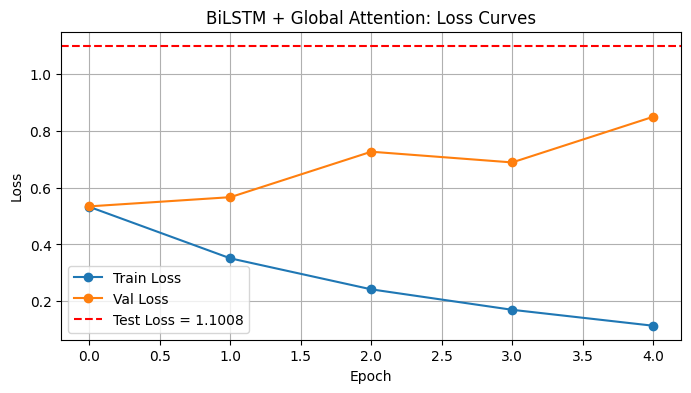

Final Test Accuracy: 0.6538


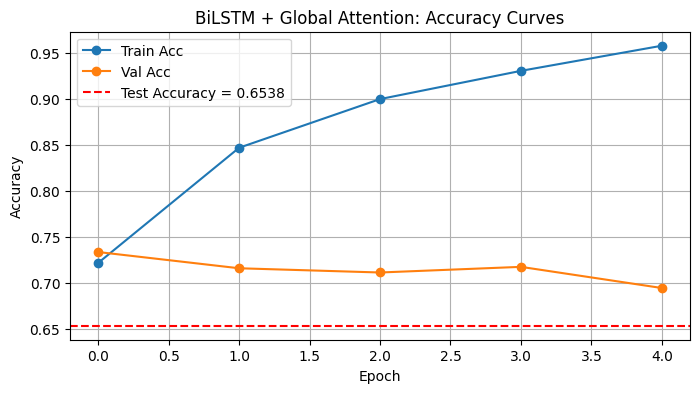

In [160]:
# --- Compute Test Loss ---
test_loss = evaluate_loss(model2_BiLSTM_GlobAttn, test_loader, DEVICE)
print(f"Final Test Loss: {test_loss:.4f}")

# --- Plot Loss ---
plt.figure(figsize=(8,4))
plt.plot(train_losses, label="Train Loss", marker="o")
plt.plot(val_losses, label="Val Loss", marker="o")
plt.axhline(test_loss, color="red", linestyle="--", label=f"Test Loss = {test_loss:.4f}")
plt.legend(); plt.title("BiLSTM + Global Attention: Loss Curves")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.grid(True); plt.show()


# --- Compute Test Loss ---
test_preds, test_labels = evaluate_model(model2_BiLSTM_GlobAttn, test_loader, DEVICE)
from sklearn.metrics import accuracy_score
test_acc = accuracy_score(test_labels, test_preds)
print(f"Final Test Accuracy: {test_acc:.4f}")

# --- Plot Accuracy ---
plt.figure(figsize=(8,4))
plt.plot(train_accs, label="Train Acc", marker="o")
plt.plot(val_accs, label="Val Acc", marker="o")
plt.axhline(test_acc, color="red", linestyle="--", label=f"Test Accuracy = {test_acc:.4f}")
plt.legend(); plt.title("BiLSTM + Global Attention: Accuracy Curves")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.grid(True); plt.show()

### Model Evaluation


Validation Report:
              precision    recall  f1-score   support

     neutral       0.73      0.61      0.66       647
     entails       0.67      0.78      0.72       657

    accuracy                           0.69      1304
   macro avg       0.70      0.69      0.69      1304
weighted avg       0.70      0.69      0.69      1304


Test Report:
              precision    recall  f1-score   support

     neutral       0.77      0.61      0.68      1284
     entails       0.55      0.72      0.62       842

    accuracy                           0.65      2126
   macro avg       0.66      0.67      0.65      2126
weighted avg       0.68      0.65      0.66      2126



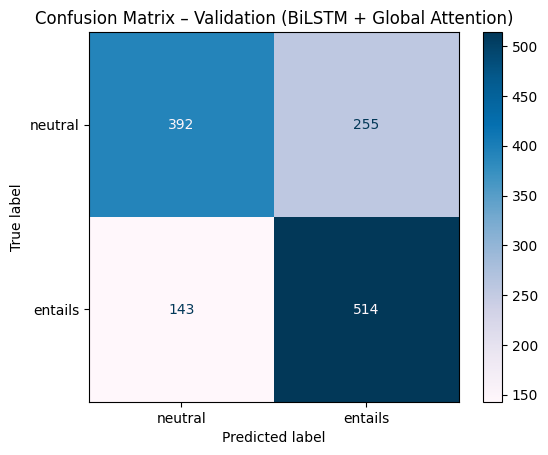

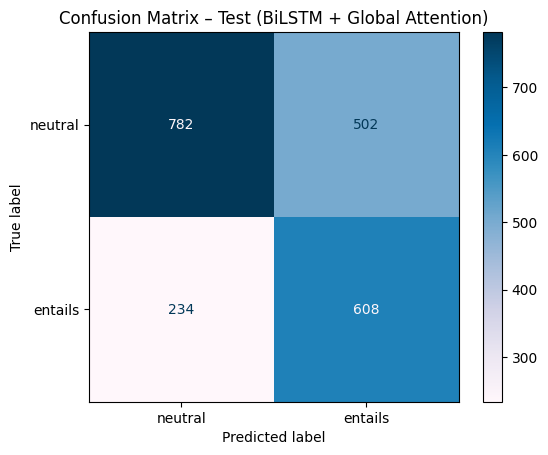

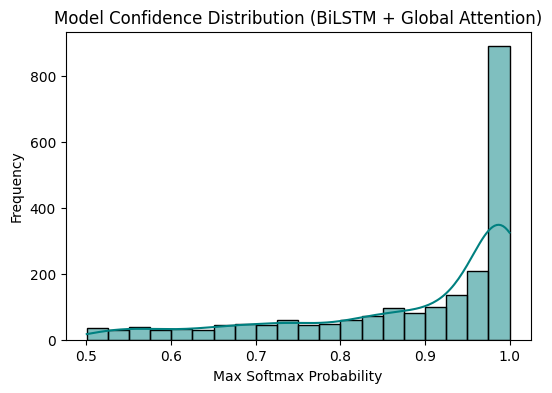

In [161]:
def evaluate_model(model, loader):
    model.eval(); preds, labels_all, probs = [], [], []
    with torch.no_grad():
        for prem, hyp, lbl in loader:
            prem, hyp, lbl = prem.to(DEVICE), hyp.to(DEVICE), lbl.to(DEVICE)
            logits = model(prem, hyp)
            prob = F.softmax(logits, dim=1)
            preds.extend(torch.argmax(prob, dim=1).cpu().numpy())
            labels_all.extend(lbl.cpu().numpy())
            probs.extend(prob.max(dim=1)[0].cpu().numpy())
    return preds, labels_all, probs

val_preds, val_labels, val_probs = evaluate_model(model2_BiLSTM_GlobAttn, val_loader)
test_preds, test_labels, test_probs = evaluate_model(model2_BiLSTM_GlobAttn, test_loader)

print("\nValidation Report:")
print(classification_report(val_labels, val_preds, target_names=["neutral","entails"]))
print("\nTest Report:")
print(classification_report(test_labels, test_preds, target_names=["neutral","entails"]))

for split, labels, preds in [("Validation", val_labels, val_preds), ("Test", test_labels, test_preds)]:
    cm = confusion_matrix(labels, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["neutral","entails"])
    disp.plot(cmap="PuBu", values_format="d")
    plt.title(f"Confusion Matrix – {split} (BiLSTM + Global Attention)")
    plt.show()

# --- Confidence Histogram ---
plt.figure(figsize=(6,4))
sns.histplot(test_probs, bins=20, kde=True, color="teal")
plt.title("Model Confidence Distribution (BiLSTM + Global Attention)")
plt.xlabel("Max Softmax Probability"); plt.ylabel("Frequency")
plt.show()

### Visualising attention

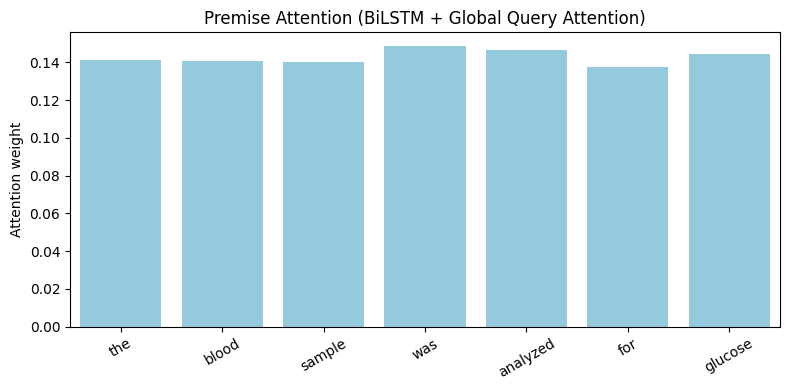

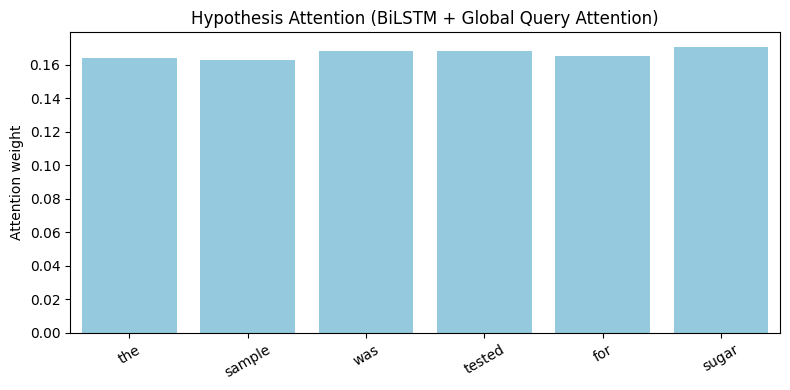

In [162]:
def visualize_attention(model, sentence, vocab, title="Attention Heatmap"):
    model.eval()
    tokens = re.sub(r"[^a-z0-9\s]", "", sentence.lower()).split()
    ids = torch.tensor([[vocab.get(tok, vocab["<unk>"]) for tok in tokens]]).to(DEVICE)
    with torch.no_grad():
        H, _ = model.bilstm(model.embedding(ids))
        _, weights = model.attn(H)
    plt.figure(figsize=(8,4))
    sns.barplot(x=tokens, y=weights.squeeze(0).cpu().numpy(), color="skyblue")
    plt.title(title); plt.ylabel("Attention weight"); plt.xticks(rotation=30)
    plt.tight_layout(); plt.show()

visualize_attention(model2_BiLSTM_GlobAttn, "the blood sample was analyzed for glucose", vocab,
                    "Premise Attention (BiLSTM + Global Query Attention)")
visualize_attention(model2_BiLSTM_GlobAttn, "the sample was tested for sugar", vocab,
                    "Hypothesis Attention (BiLSTM + Global Query Attention)")

## Export

In [163]:
# Step 4: Save Model Weights
model_path_BiLSTM_GlobalAttention = sourceFolder/"models/bilstm_globalattn_last.pt"
torch.save(model2_BiLSTM_GlobAttn.state_dict(), model_path_BiLSTM_GlobalAttention)
print(f"Model saved to {model_path_BiLSTM_GlobalAttention}")

# Step 5: Create Zip for Download
zip_path = sourceFolder/"models/bilstm_globalattn_last.zip"
with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
    zipf.write(model_path_BiLSTM_GlobalAttention, arcname=os.path.basename(model_path_BiLSTM_GlobalAttention))

print(f" Model zipped and ready for download: {zip_path}")

Model saved to /content/drive/MyDrive/nlp_grp/NLP Group Assignment (Group 18)/models/bilstm_globalattn_last.pt
 Model zipped and ready for download: /content/drive/MyDrive/nlp_grp/NLP Group Assignment (Group 18)/models/bilstm_globalattn_last.zip


In [ ]:
# best_path = sourceFolder/"models/bilstm_globalattn_best.pt"
# zip_path  = sourceFolder/"models/bilstm_globalattn_best.zip"
# with zipfile.ZipFile(zip_path, "w", zipfile.ZIP_DEFLATED) as zipf:
#     zipf.write(best_path, arcname=os.path.basename(best_path))
# print(f"Best model zipped and ready for download → {zip_path}")

In [ ]:
## UNCOMMENT TO DOWNLOAD
# from google.colab import files
# files.download(zip_path)

### Cleanup

In [164]:
import gc, torch
gc.collect()
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()


# Transformer Architechture Inspiration
NLI tasks are generally done using just the encoder only transformer architechture model which can help us to do classification task like classifying the Hypothesis and premise as `entails` or `nuetral`

We can skip the decoder model to perform NLI task as we are not generating new stream of the text.

Our inspiration to begin with such encoder model was from the transformer model architechture based on the "Attention is all you need" paper

### NLI Task Setup

We can follow BERT STYLE for our input  
```
[CLS] Premise [SEP] Hypothesis [SEP]
↓
Encoder (BERT)
↓
[CLS] → Classification head → Entail / Contradict / Neutral
```

or T5-style (Encoder-decoder style)
```
Input: "mnli premise: <text1> hypothesis: <text2>"
Output: "entailment"
```

# Transformer Architecture
- Built on encoder - decoder model
- Built entirely on self attention + feed forward network layers (No Recurrence and convolution)

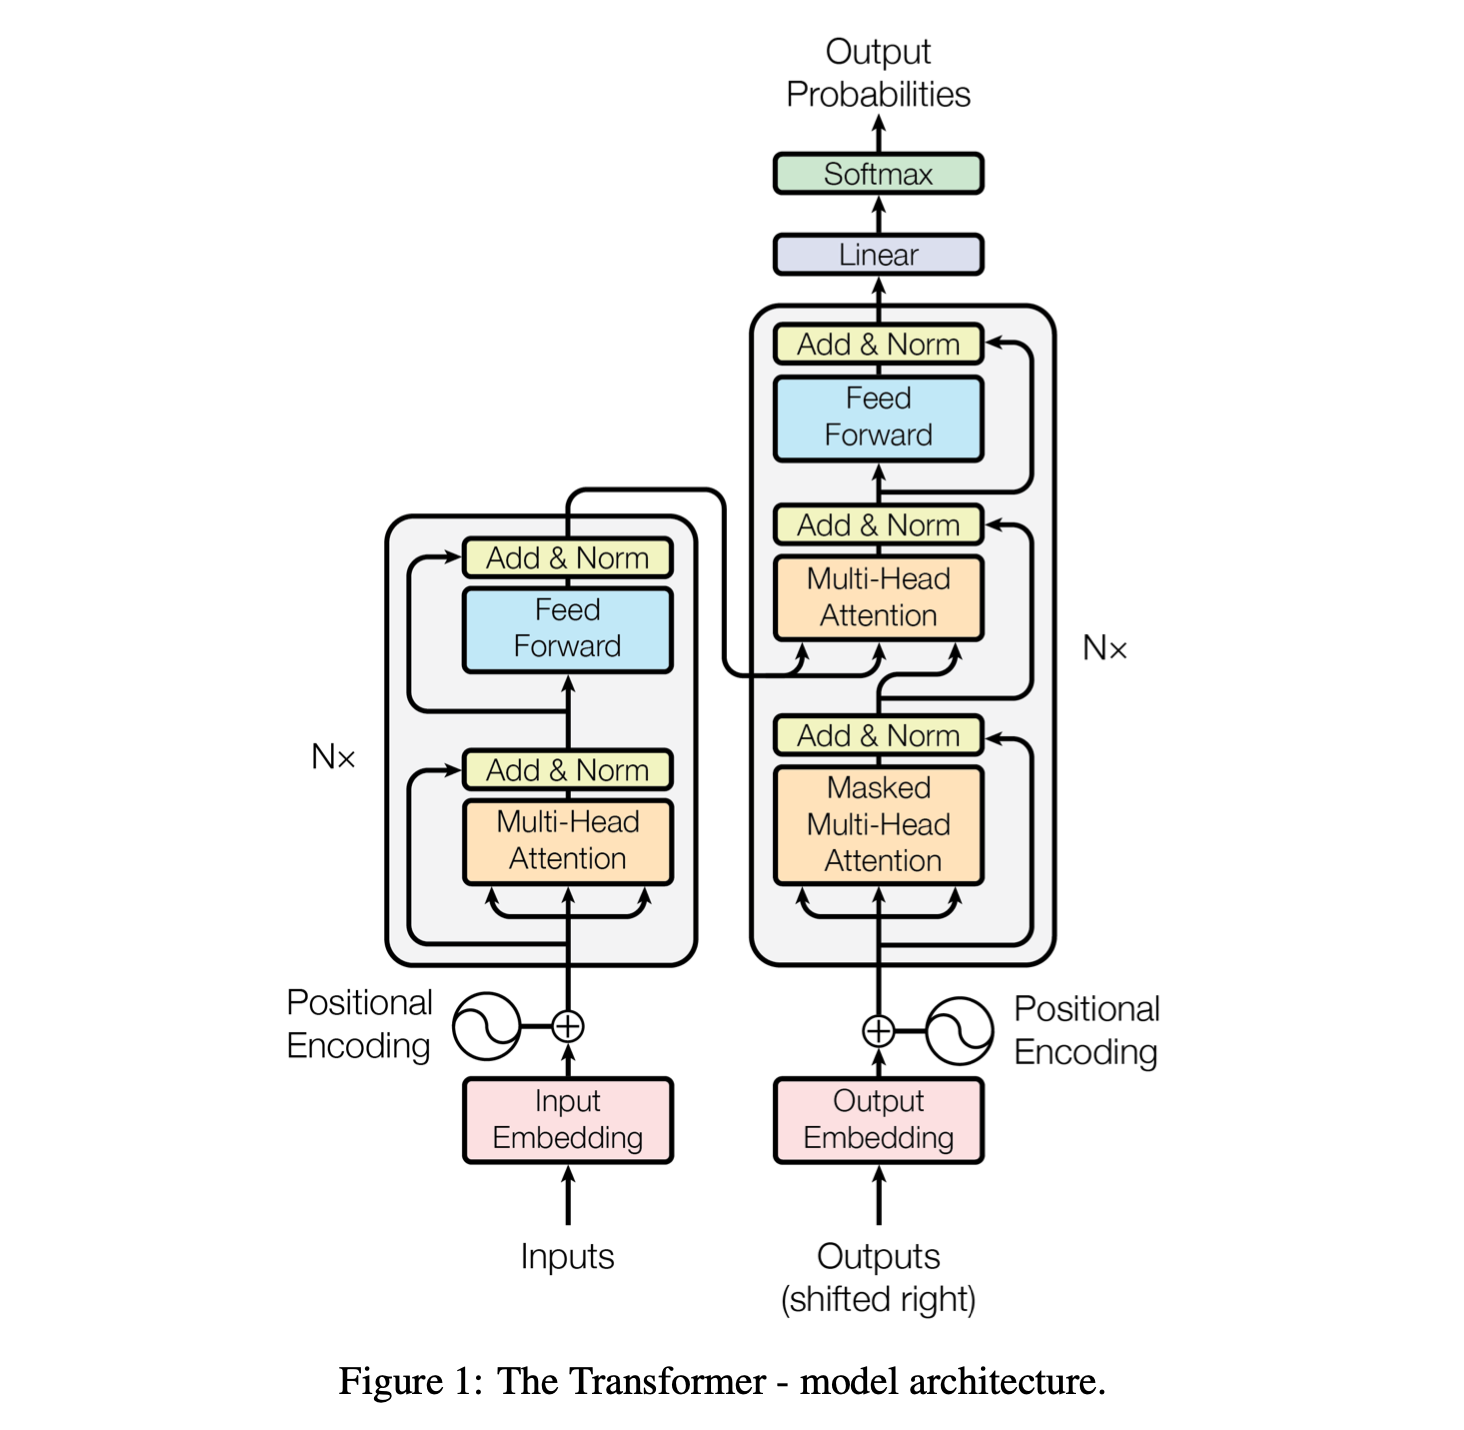

Understanding the transformer architechture
### Encoder (N times)
1. Input Embedding
2. Positional Encoding
3. MultiHead Attention + Add & Norm
4. Feed Forward + Add & Norm

### Decoder (N times)
1. Output Encoding
2. Positional Encoding
3. *Masked* MultiHead Attention + Add & Norm
4. Cross MultiHead Attention (Learnings from Encoder are embedded) + Add & Norm
5. Feed Forward + Add & Norm

### Output
1. Linear
2. Softmax

Since we are focusing on the encoder only transformer architechture we will be skipping out on the decoder part of the architechture


Encoder vs Decoder vs Full Transformer  
| Component| Core Idea | Used For | How it changes in NLI |
| ----- | ---- | ----- | ----- |
| Encoder only | Bidirectional attention sees full context | classification, sentence similarity | Best choice: can compare both texts directly |
| Decoder Only | Causal (left to right) | generation chat or reasoning | can be prompted for NLI but not trained specifically |
| Encoder-Decoder Only | Encoder reads input, decoder generates output | seq2seq (translation, summarisation) | Overhead unless you frame NLI as generation |  

Eg of different arch
- Encoder: BERT
- Decoder: GPT
- Encoder-decoder: T5/BERT

# Implementing components for Transformers

## Building Positional Encoding Module
Since transformer doesn't have idea about the previous sequence of knowledge and we need a way to embed the positional information about the data. So transformer paper suggest using of the Periodic functions which can help us out in maintaining the positional information while training.

Referrence: "Attention is all you need"

$$
\mathrm{PE}_{(pos,\,2i)} = \sin\left(\frac{pos}{10000^{\frac{2i}{d_\text{model}}}}\right)
$$

$$
\mathrm{PE}_{(pos,\,2i+1)} = \cos\left(\frac{pos}{10000^{\frac{2i}{d_\text{model}}}}\right)
$$

- pos: position of the token in the sequence (0, 1, 2, …)
- i: dimension index (0, 1, 2, …)
- d_{model}: the total embedding dimension (e.g., 512)
- 2i and 2i+1 split sine and cosine across even and odd indices

Basically we are using two formula based on the token's position. If the token is even or odd and then we use either cos or sin

In [ ]:
class Sinusoidal_Positional_Encoding(nn.Module):
    """
    d_model: Embedding dimension which is same as the input embedding dimension
    max_seq_len: the maximum length of the input sequence
    """
    def __init__(self, d_model: int, max_seq_len: int = 1000):
        super().__init__()
        self.d_model = d_model
        self.max_seq_len = max_seq_len
        # Positional Encoding Matrix
        pe = torch.zeros(max_seq_len, d_model)    # creating a zero matrix of shape of the maximum sequence length and the embedding dimension
        position = torch.arange(0, max_seq_len, dtype=torch.float).unsqueeze(1)     # creating a position matrix of shape of the maximum sequence length
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000)/ d_model))
        pe[:, 0::2] = torch.sin(position * div_term)        # for even index
        pe[:, 1::2] = torch.cos(position * div_term)        # for odd index
        self.register_buffer("pe", pe)  # this is a buffer which becomes a parameter of the model without gradients

    def forward(self, x: torch.Tensor):
        # x: (B, T, d_model)
        B, T, _ = x.shape
        return x + self.pe[:T, :].unsqueeze(0)

In [ ]:
class LearnedPositionalEncoding(nn.Module):
    """
    d_model: embedding dimension
    max_len: maximum length of the sequence
    """
    def __init__(self, d_model: int, max_len: int = 1000):
        super().__init__()
        self.emb = nn.Embedding(max_len, d_model)

    def forward(self, x: torch.Tensor):
        # x: (B, T, d_model)
        B, T, _ = x.shape
        pos = torch.arange(T, device=x.device)
        pos_emb = self.emb(pos)
        return x + pos_emb.unsqueeze(0)

## Single Head Self Attention

### Masking
Masking is present in the multi head attention module present in decoder part of the transformer model.
This helps the model to avoid using the next tokens in the sequence for training

In [ ]:
def casual_mask(T: int, device: torch.device)->torch.Tensor:
    """
    Returns a bool mask where True means *masked*
    """

    m = torch.triu(torch.ones(T, T, device=device), diagonal=1)
    return m.view(1,1,T,T)

### Attention
Referrence "Attention is all you need"

Here the attention head created is based on the scaled dot-product attention formula presented in the transformers paper  
**Scaled Dot-Product Attention Formula** : The scaled dot-product attention computes attention scores as:

$$
\text{Attention}(Q, K, V) = \text{softmax}\left( \frac{Q K^T}{\sqrt{d_k}} \right) V
$$

where:
- \( Q \) = queries,
- \( K \) = keys,
- \( V \) = values,
- \( d_k \) = dimensionality of keys.


> Insert the Attention Image here

We are implementing the Scaled Dot Product (Left Diagram)

In [ ]:
class Single_Head_Self_Attention(nn.Module):
    """
    Single-Head Attention
    args:
        d_model: embedding dimension
        d_k: dimension of the key, value and
        dropout: dropout rate
        trace_shapes: whether to trace the shapes of the tensors for debugging
    """
    def __init__(self, d_model: int, d_k: int, dropout: float = 0.0, causal: bool = True, trace_shapes: bool = False):
        super().__init__()
        self.d_k = d_k  # Store d_k as instance variable for use in forward
        self.q = nn.Linear(d_model, d_k, bias=False)
        self.k = nn.Linear(d_model, d_k, bias=False)
        self.v = nn.Linear(d_model, d_k, bias=False)
        self.dropout = nn.Dropout(dropout)
        self.causal = causal
        self.trace_shapes = trace_shapes

    def forward(self, x: torch.Tensor):  # (B, T, d_model)
        batch_size, seq_len, _ = x.shape
        q = self.q(x)    # (Batch_size, Seq_len, d_k)
        k = self.k(x)    # (Batch_size, Seq_len, d_k)
        v = self.v(x)    # (Batch_size, Seq_len, d_k)
        if self.trace_shapes:
            print(f"q: {tuple(q.shape)}")
            print(f"k: {tuple(k.shape)}")
            print(f"v: {tuple(v.shape)}")

        # Applying the scaled dot-product attention formula
        scale = 1.0 / math.sqrt(self.d_k)
        attention = torch.matmul(q, k.transpose(-2, -1)) * scale   # (Batch_size, Seq_len, Seq_len)

        # Masking the upper triangle of the attention matrix
        # Why? To prevent the model from attending to future tokens during training
        if self.causal:
            mask = casual_mask(seq_len, device=x.device)
            attention = attention.masked_fill(mask.squeeze(1), float("-inf"))
        w = F.softmax(attention, dim=-1)
        w = self.dropout(w)
        out = torch.matmul(w, v)   # (Batch_size, Seq_len, d_k)
        if self.trace_shapes:
            print(f"Weights: {tuple(w.shape)} Out {out.shape}")
        return out, w


## Building multi head attention module

> Attach the attention image here

We are now implementing the Multiple Scaled Dot Product which are stacked (Right Diagram)

In [ ]:
class Multi_Head_Self_Attention(nn.Module):
    """
    Multi-Head Attention
    This represent one multi head self attention block

    args:
        d_model: embedding dimension
        n_heads: number of attention heads
        dropout: dropout rate
        trace_shapes: whether to trace the shapes of the tensors for debugging

    note:
        d_k (d_head here) ie, dimension of the key, value and query is same as d_model / n_heads
    """
    def __init__(self, d_model: int, n_heads: int, dropout: float = 0.0, causal: bool = True, trace_shapes: bool = False):
        super().__init__()
        assert d_model % n_heads == 0, "d_model must be divisible by n_heads"
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_head = d_model // n_heads
        self.dropout = nn.Dropout(dropout)
        self.causal = causal
        self.trace_shapes = trace_shapes

        self.qkv = nn.Linear(d_model, 3 * d_model, bias=False)      # we need to project the input to 3 times the dimension of the input so that we can split it into query, key and value
        self.proj = nn.Linear(d_model, d_model, bias=False)         # after the attention computation, we need to project the output back to the original dimension


    def forward(self, x: torch.Tensor):
        batch_size, seq_len, C = x.shape   # c is the embedding dimension
        qkv = self.qkv(x)
        qkv = qkv.view(batch_size, seq_len, 3, self.n_heads, self.d_head)
        q, k, v = qkv.unbind(dim=2)
        q = q.transpose(1, 2)
        k = k.transpose(1, 2)
        v = v.transpose(1, 2)

        if self.trace_shapes:
            print(f"q: {tuple(q.shape)}")
            print(f"k: {tuple(k.shape)}")
            print(f"v: {tuple(v.shape)}")

        scale = 1.0 / math.sqrt(self.d_head)
        attention = torch.matmul(q, k.transpose(-2, -1)) * scale

        # mask out the upper triangle of the attention matrix
        if self.causal:
            mask = casual_mask(seq_len, device=x.device)
            attention = attention.masked_fill(mask, float("-inf"))

        w = F.softmax(attention, dim=-1)
        w = self.dropout(w)
        ctx = torch.matmul(w, v)
        if self.trace_shapes:
            print(f"ctx: {tuple(ctx.shape)}")
        ctx = ctx.transpose(1, 2)
        # we need to make sure that the context is contiguous
        # because the view operation is not guaranteed to be contiguous
        # if it is not contiguous, the view operation will throw an error
        # contiguous means that the memory is in a contiguous block
        ctx = ctx.contiguous().view(batch_size, seq_len, C)
        out = self.proj(ctx)
        return out


# Building Cross Attention

## Cross-Attention for Decoder

Cross-attention is a key component of the transformer decoder. Unlike self-attention where queries, keys, and values all come from the same sequence, in cross-attention:
- **Queries (Q)**: Come from the decoder (target sequence)
- **Keys (K) and Values (V)**: Come from the encoder (source sequence)

This allows the decoder to attend to the encoder's representations while generating the target sequence.


In [ ]:
class CrossAttention(nn.Module):
    """
    Cross-Attention mechanism for transformer decoder.

    In cross-attention:
    - Queries come from decoder (target sequence)
    - Keys and Values come from encoder (source sequence)

    Args:
        d_model: embedding dimension
        n_heads: number of attention heads
        dropout: dropout rate
        trace_shapes: whether to trace tensor shapes for debugging
    """

    def __init__(self, d_model: int, n_heads: int, dropout: float = 0.0, trace_shapes: bool = False):
        super().__init__()
        assert d_model % n_heads == 0, "d_model must be divisible by n_heads"

        self.d_model = d_model
        self.n_heads = n_heads
        self.d_head = d_model // n_heads
        self.dropout = nn.Dropout(dropout)
        self.trace_shapes = trace_shapes

        # Separate projections for queries (from decoder) and keys/values (from encoder)
        self.q_proj = nn.Linear(d_model, d_model, bias=False)  # Queries from decoder
        self.kv_proj = nn.Linear(d_model, 2 * d_model, bias=False)  # Keys and Values from encoder
        self.out_proj = nn.Linear(d_model, d_model, bias=False)  # Output projection

    def forward(self, decoder_hidden: torch.Tensor, encoder_output: torch.Tensor,
                src_mask: torch.Tensor = None) -> torch.Tensor:
        """
        Args:
            decoder_hidden: decoder representations (B, tgt_len, d_model)
            encoder_output: encoder representations (B, src_len, d_model)
            src_mask: source padding mask (B, src_len) - True for padding positions
        Returns:
            output: cross-attended representations (B, tgt_len, d_model)
        """
        B, tgt_len, _ = decoder_hidden.shape
        B, src_len, _ = encoder_output.shape

        # Generate queries from decoder hidden states
        q = self.q_proj(decoder_hidden)  # (B, tgt_len, d_model)

        # Generate keys and values from encoder output
        kv = self.kv_proj(encoder_output)  # (B, src_len, 2 * d_model)

        # Reshape for multi-head attention
        q = q.view(B, tgt_len, self.n_heads, self.d_head).transpose(1, 2)  # (B, n_heads, tgt_len, d_head)
        kv = kv.view(B, src_len, 2, self.n_heads, self.d_head)
        k, v = kv.unbind(dim=2)  # Each: (B, src_len, n_heads, d_head)
        k = k.transpose(1, 2)  # (B, n_heads, src_len, d_head)
        v = v.transpose(1, 2)  # (B, n_heads, src_len, d_head)

        if self.trace_shapes:
            print(f"Cross-attention - q: {tuple(q.shape)}, k: {tuple(k.shape)}, v: {tuple(v.shape)}")

        # Scaled dot-product attention
        scale = 1.0 / math.sqrt(self.d_head)
        attention_scores = torch.matmul(q, k.transpose(-2, -1)) * scale  # (B, n_heads, tgt_len, src_len)

        # Apply source mask if provided (mask out padding tokens in source)
        if src_mask is not None:
            # Expand mask for multi-head attention: (B, 1, 1, src_len)
            src_mask = src_mask.unsqueeze(1).unsqueeze(2)
            attention_scores = attention_scores.masked_fill(src_mask, float('-inf'))

        # Softmax to get attention weights
        attention_weights = F.softmax(attention_scores, dim=-1)
        attention_weights = self.dropout(attention_weights)

        # Apply attention to values
        context = torch.matmul(attention_weights, v)  # (B, n_heads, tgt_len, d_head)

        if self.trace_shapes:
            print(f"Cross-attention context: {tuple(context.shape)}")

        # Concatenate heads and project
        context = context.transpose(1, 2).contiguous().view(B, tgt_len, self.d_model)
        output = self.out_proj(context)

        return output


## Feedforward

In [ ]:
## Building simple feed forward network with GELU activation
class FeedForward(nn.Module):
    """
    Position-wise Feed Forward Network

    Args:
        d_model: input/output dimension
        d_ff : hidden dimension
        dropout: dropout rate
    """

    def __init__(self, d_model: int, d_ff: int, dropout: float = 0.1):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor):
        """
        x : (Batch_size, Seq_len, d_model)
        returns : (Batch_size, Seq_len, d_model)
        """
        x = self.linear1(x)
        x = F.gelu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        return x

## Building Layer normalization
mean of all features
$$
\mu = \frac{1}{D} \sum_{i=1}^{D} x_i, \quad
$$

variabce of all features
$$
\sigma^2 = \frac{1}{D} \sum_{i=1}^{D} (x_i - \mu)^2
$$

$$
\text{LayerNorm}(x_i) = \gamma \cdot \frac{x_i - \mu}{\sqrt{\sigma^2 + \epsilon}} + \beta
$$

In [ ]:
class LayerNorm(nn.Module):
    """
    Layer Normalization

    Args:
        d_model : dimension to normalize over
        eps : using small value to avoid division by zero
        bias : boolean to include bias or not
    """

    def __init__(self, d_model: int, eps: float = 1e-5, bias: bool = True):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(d_model))
        self.bias = nn.Parameter(torch.zeros(d_model)) if bias else None

    def forward(self, x: torch.Tensor):
        """
        x : (Batch_size, Seq_len, d_model)
        returns : (Batch_size, Seq_len, d_model)
        """
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        normalized = (x - mean) / torch.sqrt(var + self.eps)
        normalized = normalized * self.weight
        if self.bias is not None:
            normalized = normalized + self.bias
        return normalized



we can use nn.LayerNormalization from pytorch to implement the layernormalization directly

In [ ]:
# LayerNorm = nn.LayerNorm(d_model, eps=1e-5, elementwise_affine=True)
# elementwise_affine = True means that the layer normalization will have learnable parameters ie, weights and biases
# if we set it to False, the layer normalization will not have any learnable parameters and it will be a simple layer normalization

In [ ]:
class Residual_Connection(nn.Module):
    """
    Residual connection with layer normalization.
    It supports both pre normalization and post normalization
    """
    def __init__(self, d_model: int, dropout: float = 0.1, bias: bool = True, pre_norm: bool = True):
        super().__init__()
        self.norm = nn.LayerNorm(d_model, eps=1e-5, elementwise_affine=bias)
        self.dropout = nn.Dropout(dropout)
        self.pre_norm = pre_norm

    def forward(self, x, sublayer) -> torch.Tensor:
        """
        Apply residual connection to any sublayer with the same size

        Args:
            x: input tensor (batch_size, seq_len, d_model)
            sublayer: function that takes x and returns tensor of same shape
        Returns:
            output: (batch_size, seq_len, d_model)
        """
        if self.pre_norm:
            return x + self.dropout(sublayer(self.norm(x)))
        else:
            return self.norm(x + self.dropout(sublayer(x)))


In [ ]:
class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    This is a convenience wrapper that combines residual connection and layer norm.
    """
    def __init__(self, d_model: int, dropout: float = 0.1):
        super().__init__()
        self.norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer) -> torch.Tensor:
        return x + self.dropout(sublayer(self.norm(x)))


# Encoder Flow
```
Input: x (batch_size, seq_len, d_model)
    ↓
1. Attention + Residual:
   x = x + dropout(self_attention(layer_norm(x)))
    ↓  
2. Feed Forward + Residual:
   x = x + dropout(feed_forward(layer_norm(x)))
    ↓
Output: x (batch_size, seq_len, d_model)
```

## Encoder block

In [ ]:
class TransformerEncoderBlock(nn.Module):
    """
    A single transformer encoder block

    Args:
        d_model: model dimension
        n_heads: number of attention heads
        d_ff: feed forward hidden dimension
        dropout: dropout rate
        trace_shapes: whether to trace tensor shapes for debugging
    """
    def __init__(self, d_model: int, n_heads: int, d_ff: int, dropout: float = 0.1, trace_shapes: bool = False):
        super().__init__()
        self.d_model = d_model
        self.trace_shapes = trace_shapes

        self.self_attention = Multi_Head_Self_Attention(
            d_model=d_model,
            n_heads=n_heads,
            dropout=dropout,
            trace_shapes=trace_shapes,
            causal=False
        )

        self.feed_forward = FeedForward(
            d_model = d_model,
            d_ff = d_ff,
            dropout = dropout
        )

        self.sublayer1 = SublayerConnection(d_model, dropout)
        self.sublayer2 = SublayerConnection(d_model, dropout)

    def forward(self, x: torch.Tensor, mask: torch.Tensor = None) -> torch.Tensor:
        """
        Forward pass through the encoder block

        Args:
            x: input tensor (batch_size, seq_len, d_model)
            mask: attention_mask (batch_size, seq_len) - True for positions to mask

        Returns:
            output: (batch_size, seq_len, d_model)
        """
        if self.trace_shapes:
            print(f"EncoderBlock input: {tuple(x.shape)}")

        # Self-attention with residual connection
        x = self.sublayer1(x, lambda x: self.self_attention(x))
        if self.trace_shapes:
            print(f"After self-attention: {tuple(x.shape)}")

        # Feed forward with residual connection
        x = self.sublayer2(x, lambda x: self.feed_forward(x))

        if self.trace_shapes:
            print(f"EncoderBlock output: {tuple(x.shape)}")

        return x

## Stacked Encoder Block

In [ ]:
class TransformerEncoder(nn.Module):
    """
    Stack of N transformer encoder blocks.

    Args:
        n_layers: number of encoder blocks
        d_model: model dimension
        n_heads: number of attention heads
        d_ff: feed forward hidden dimension
        dropout: dropout rate
        trace_shapes: whether to trace tensor shapes for debugging
    """

    def __init__(self, n_layers: int, d_model: int, n_heads: int, d_ff: int, dropout: float = 0.1, trace_shapes: bool = False):
        super().__init__()
        self.layers = nn.ModuleList([
            TransformerEncoderBlock(
                d_model=d_model,
                n_heads=n_heads,
                d_ff=d_ff,
                dropout=dropout,
                trace_shapes=trace_shapes
            )
            for _ in range(n_layers)
        ])

    def forward(self, x: torch.Tensor, mask: torch.Tensor = None) -> torch.Tensor:
        """
        Forward pass through the stacked encoder blocks
        mask: attention mask (batch_size, seq_len) - True for positions to mask

        Returns:
            output: (batch_size, seq_len, d_model)
        """
        for layer in self.layers:
            x = layer(x, mask)
        return x

# Model 3: Encoder Only Transformer Training (Sinusoidal Positional Encoder)

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import numpy as np
from typing import Dict, List, Tuple, Optional
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

## Dataset Preparation for Transformers

### Building Vocabulary for Transformers

In [ ]:
def build_transformer_vocab(
    train_df,
    val_df,
    test_df,
    token_columns=['premise_tokens', 'hypothesis_tokens']
) -> Dict[str, int]:
    """
    Build vocabulary with special tokens for transformer.

    Special tokens:
        [PAD]: 0
        [UNK]: 100
        [CLS]: 101
        [SEP]: 102

    Args:
        train_df, val_df, test_df: dataframes with tokenized columns
        token_columns: columns containing token lists

    Returns:
        vocab: dictionary mapping tokens to IDs
    """
    # Collect all tokens
    all_tokens = set()
    for df in [train_df, val_df, test_df]:
        for col in token_columns:
            for token_list in df[col]:
                all_tokens.update(token_list)

    # Build vocab with special tokens
    vocab = {
        '[PAD]': 0,
        '[UNK]': 100,
        '[CLS]': 101,
        '[SEP]': 102
    }

    # Add regular tokens starting from 103
    next_id = 103
    for token in sorted(all_tokens):
        if token not in vocab:
            vocab[token] = next_id
            next_id += 1

    print(f"Vocabulary built. Size: {len(vocab)}")
    print(f"Special tokens: [PAD]={vocab['[PAD]']}, [UNK]={vocab['[UNK]']}, "
          f"[CLS]={vocab['[CLS]']}, [SEP]={vocab['[SEP]']}")

    return vocab

Building the transformer vocabulary

In [ ]:
print("Building transformer vocabulary...")
vocab_transformer = build_transformer_vocab(train_df, val_df, test_df)

print(f"\nSample tokens from vocabulary:")
sample_tokens = list(vocab_transformer.items())[:15]
for token, idx in sample_tokens:
    print(f"  '{token}': {idx}")

Building transformer vocabulary...
Vocabulary built. Size: 21424
Special tokens: [PAD]=0, [UNK]=100, [CLS]=101, [SEP]=102

Sample tokens from vocabulary:
  '[PAD]': 0
  '[UNK]': 100
  '[CLS]': 101
  '[SEP]': 102
  '0': 103
  '000': 104
  '000001meterdiameter': 105
  '000010m': 106
  '0001': 107
  '000338324205530': 108
  '0010': 109
  '0035': 110
  '004': 111
  '0055': 112
  '0075ml': 113


### Building Dataset

In [ ]:
class TransformerNLIDataset(Dataset):
    """
    Dataset class for NLI task with transformer-style formatting.

    Formats input as: [CLS] premise [SEP] hypothesis [SEP]

    Args:
        premises: list of premise token lists
        hypotheses: list of hypothesis token lists
        labels: list of label IDs
        vocab: vocabulary dictionary (word -> id)
        max_seq_len: maximum sequence length
        cls_token_id: CLS token ID (default: 101)
        sep_token_id: SEP token ID (default: 102)
        pad_token_id: PAD token ID (default: 0)
    """

    def __init__(
        self,
        premises: List[List[str]],
        hypotheses: List[List[str]],
        labels: List[int],
        vocab: Dict[str, int],
        max_seq_len: int = 256,
        cls_token_id: int = 101,
        sep_token_id: int = 102,
        pad_token_id: int = 0,
        unk_token_id: int = 100
    ):
        self.premises = premises
        self.hypotheses = hypotheses
        self.labels = labels
        self.vocab = vocab
        self.max_seq_len = max_seq_len
        self.cls_token_id = cls_token_id
        self.sep_token_id = sep_token_id
        self.pad_token_id = pad_token_id
        self.unk_token_id = unk_token_id

    def __len__(self):
        return len(self.labels)

    def _encode_tokens(self, tokens: List[str]) -> List[int]:
        """Convert tokens to IDs using vocabulary."""
        return [self.vocab.get(tok, self.unk_token_id) for tok in tokens]

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, int]:
        """
        Returns:
            input_ids: combined sequence [CLS] premise [SEP] hypothesis [SEP]
            segment_ids: 0 for [CLS]+premise, 1 for hypothesis+[SEP]
            attention_mask: 1 for real tokens, 0 for padding
            label: label ID
        """
        premise_tokens = self.premises[idx]
        hypothesis_tokens = self.hypotheses[idx]
        label = self.labels[idx]

        # Encode tokens to IDs
        premise_ids = self._encode_tokens(premise_tokens)
        hypothesis_ids = self._encode_tokens(hypothesis_tokens)

        # Calculate max lengths for truncation
        # Reserve 3 positions for [CLS] and 2x [SEP]
        max_len_each = (self.max_seq_len - 3) // 2

        # Truncate if necessary
        if len(premise_ids) > max_len_each:
            premise_ids = premise_ids[:max_len_each]
        if len(hypothesis_ids) > max_len_each:
            hypothesis_ids = hypothesis_ids[:max_len_each]

        # Build sequence: [CLS] premise [SEP] hypothesis [SEP]
        input_ids = [self.cls_token_id] + premise_ids + [self.sep_token_id] + \
                    hypothesis_ids + [self.sep_token_id]

        # Create segment IDs: 0 for [CLS] and premise, 1 for hypothesis
        premise_len = len(premise_ids) + 2  # +2 for [CLS] and first [SEP]
        segment_ids = [0] * premise_len + [1] * (len(input_ids) - premise_len)

        # Create attention mask (all 1s for now, padding will be added in collate_fn)
        attention_mask = [1] * len(input_ids)

        return (
            torch.tensor(input_ids, dtype=torch.long),
            torch.tensor(segment_ids, dtype=torch.long),
            torch.tensor(attention_mask, dtype=torch.long),
            label
        )

In [ ]:
def transformer_collate_fn(batch, pad_token_id: int = 0):
    """
    Collate function for batching with dynamic padding.

    Args:
        batch: list of tuples (input_ids, segment_ids, attention_mask, label)
        pad_token_id: ID for padding token

    Returns:
        input_ids: (batch_size, max_len)
        segment_ids: (batch_size, max_len)
        attention_mask: (batch_size, max_len)
        labels: (batch_size,)
    """
    input_ids, segment_ids, attention_masks, labels = zip(*batch)

    # Pad sequences
    input_ids_padded = pad_sequence(input_ids, batch_first=True, padding_value=pad_token_id)
    segment_ids_padded = pad_sequence(segment_ids, batch_first=True, padding_value=0)
    attention_masks_padded = pad_sequence(attention_masks, batch_first=True, padding_value=0)
    labels_tensor = torch.tensor(labels, dtype=torch.long)

    return input_ids_padded, segment_ids_padded, attention_masks_padded, labels_tensor


### Create Dataloader for Transformer

In [ ]:
def create_transformer_dataloaders(
    train_df,
    val_df,
    test_df,
    vocab: Dict[str, int],
    batch_size: int = 32,
    max_seq_len: int = 256,
    num_workers: int = 0
) -> Tuple[DataLoader, DataLoader, DataLoader]:
    """
    Create DataLoaders for transformer training.

    Args:
        train_df, val_df, test_df: dataframes with columns:
            - premise_tokens: list of tokens
            - hypothesis_tokens: list of tokens
            - label_id: integer label
        vocab: vocabulary dictionary
        batch_size: batch size
        max_seq_len: maximum sequence length
        num_workers: number of data loading workers

    Returns:
        train_loader, val_loader, test_loader
    """
    # Create datasets
    train_dataset = TransformerNLIDataset(
        premises=train_df['premise_tokens'].tolist(),
        hypotheses=train_df['hypothesis_tokens'].tolist(),
        labels=train_df['label_id'].tolist(),
        vocab=vocab,
        max_seq_len=max_seq_len
    )

    val_dataset = TransformerNLIDataset(
        premises=val_df['premise_tokens'].tolist(),
        hypotheses=val_df['hypothesis_tokens'].tolist(),
        labels=val_df['label_id'].tolist(),
        vocab=vocab,
        max_seq_len=max_seq_len
    )

    test_dataset = TransformerNLIDataset(
        premises=test_df['premise_tokens'].tolist(),
        hypotheses=test_df['hypothesis_tokens'].tolist(),
        labels=test_df['label_id'].tolist(),
        vocab=vocab,
        max_seq_len=max_seq_len
    )

    # Create collate function with pad_token_id
    collate_fn = lambda batch: transformer_collate_fn(batch, pad_token_id=vocab['[PAD]'])

    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=collate_fn,
        num_workers=num_workers
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        collate_fn=collate_fn,
        num_workers=num_workers
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        collate_fn=collate_fn,
        num_workers=num_workers
    )

    print(f"DataLoaders created:")
    print(f"  Train batches: {len(train_loader)}")
    print(f"  Val batches: {len(val_loader)}")
    print(f"  Test batches: {len(test_loader)}")

    return train_loader, val_loader, test_loader

In [ ]:
BATCH_SIZE = 32
MAX_SEQ_LEN = 128  # Sufficient for SNLI, shorter = faster training

In [ ]:
print(f"Creating dataloaders (batch_size={BATCH_SIZE}, max_seq_len={MAX_SEQ_LEN})...")

train_loader_tf, val_loader_tf, test_loader_tf = create_transformer_dataloaders(
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    vocab=vocab_transformer,
    batch_size=BATCH_SIZE,
    max_seq_len=MAX_SEQ_LEN,
    num_workers=0
)

Creating dataloaders (batch_size=32, max_seq_len=128)...
DataLoaders created:
  Train batches: 721
  Val batches: 41
  Test batches: 67


### Transformer Data Verfication

In [ ]:
input_ids, segment_ids, attention_mask, labels = next(iter(train_loader_tf))
print(f"Input IDs shape: {input_ids.shape}")
print(f"Segment IDs shape: {segment_ids.shape}")
print(f"Attention Mask shape: {attention_mask.shape}")
print(f"Labels shape: {labels.shape}")

Input IDs shape: torch.Size([32, 64])
Segment IDs shape: torch.Size([32, 64])
Attention Mask shape: torch.Size([32, 64])
Labels shape: torch.Size([32])


In [ ]:
# Decode first example to verify format
inv_vocab = {v: k for k, v in vocab_transformer.items()}
first_example = [inv_vocab.get(id.item(), '[UNK]') for id in input_ids[0]]
print(f"\nFirst example (decoded):")
print(f"  {' '.join(first_example[:])}")
print(f"  Label: {labels[0].item()} {label_map}")
print("="*70)



First example (decoded):
  [CLS] there are many possible source of error in this experiment [SEP] you decrease error in an experiment by take many measurement [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
  Label: 0 {'entails': 1, 'neutral': 0}


## Transformer For NLI


In [ ]:
from dataclasses import dataclass

@dataclass
class TransformerConfig:
    """
    Configuration class for Transformer models.

    This class stores all the hyperparameters needed to build a transformer model.
    """

    # Model architecture
    vocab_size: int = 30522  # BERT-base vocabulary size
    d_model: int = 768       # Hidden size / embedding dimension
    n_layers: int = 12       # Number of transformer layers
    n_heads: int = 12        # Number of attention heads
    d_ff: int = 3072         # Feed forward hidden dimension (typically 4 * d_model)

    # Sequence and embedding parameters
    max_seq_len: int = 512   # Maximum sequence length
    n_segments: int = 2      # Number of segment types (for NLI: premise/hypothesis)
    pos_encoding_type: str = 'sinusoidal'  # 'sinusoidal' or 'learned'

    # Regularization
    dropout: float = 0.1     # Dropout rate
    attention_dropout: float = 0.1  # Attention dropout rate

    # Special tokens
    pad_token_id: int = 0    # Padding token ID
    cls_token_id: int = 101  # CLS token ID (BERT-style)
    sep_token_id: int = 102  # SEP token ID (BERT-style)
    unk_token_id: int = 100  # Unknown token ID

    # Task-specific parameters
    num_labels: int = 3      # Number of output classes (for NLI: entailment, contradiction, neutral)

    # Training parameters
    initializer_range: float = 0.02  # Standard deviation for weight initialization
    layer_norm_eps: float = 1e-12    # Layer normalization epsilon

    # Debugging
    trace_shapes: bool = False  # Whether to trace tensor shapes

    def __post_init__(self):
        """Validate configuration parameters."""
        assert self.d_model % self.n_heads == 0, "d_model must be divisible by n_heads"
        assert self.d_ff > 0, "d_ff must be positive"
        assert self.n_layers > 0, "n_layers must be positive"
        assert self.vocab_size > 0, "vocab_size must be positive"
        assert self.max_seq_len > 0, "max_seq_len must be positive"
        assert 0 <= self.dropout <= 1, "dropout must be between 0 and 1"
        assert self.pos_encoding_type in ['sinusoidal', 'learned'], "pos_encoding_type must be 'sinusoidal' or 'learned'"

@dataclass
class NLIConfig(TransformerConfig):
    """
    Configuration specifically for Natural Language Inference tasks.

    Inherits from TransformerConfig and sets NLI-specific defaults.
    """

    # NLI-specific defaults
    num_labels: int = 3      # entailment, contradiction, neutral
    n_segments: int = 2      # premise and hypothesis
    max_seq_len: int = 512   # Typical for NLI tasks

    # Label mapping
    label2id: dict = None
    id2label: dict = None

    def __post_init__(self):
        super().__post_init__()

        # Set default label mappings if not provided
        if self.label2id is None:
            self.label2id = {
                'entailment': 0,
                'neutral': 1,
                'contradiction': 2
            }

        if self.id2label is None:
            self.id2label = {v: k for k, v in self.label2id.items()}

## Embeddings

In [ ]:
class TokenEmbedding(nn.Module):
    """
    Token embedding layer that converts token IDs to dense vectors.

    Args:
        vocab_size: size of the vocabulary
        d_model: embedding dimension
        padding_idx: index used for padding tokens
    """

    def __init__(self, vocab_size: int, d_model: int, padding_idx: int = 0):
        super().__init__()
        self.d_model = d_model
        self.embedding = nn.Embedding(vocab_size, d_model, padding_idx=padding_idx)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: token IDs (batch_size, seq_len)
        Returns:
            embeddings: (batch_size, seq_len, d_model)
        """
        # Scale embeddings by sqrt(d_model) as in the original paper
        return self.embedding(x) * (self.d_model ** 0.5)

In [ ]:
class SegmentEmbedding(nn.Module):
    """
    Segment embedding to distinguish between premise and hypothesis.

    For NLI tasks:
    - Segment 0: [CLS] and premise tokens
    - Segment 1: hypothesis tokens and [SEP]

    Args:
        d_model: embedding dimension
        n_segments: number of segments (typically 2 for NLI)
    """

    def __init__(self, d_model: int, n_segments: int = 2):
        super().__init__()
        self.embedding = nn.Embedding(n_segments, d_model)

    def forward(self, segment_ids: torch.Tensor) -> torch.Tensor:
        """
        Args:
            segment_ids: segment IDs (batch_size, seq_len)
        Returns:
            embeddings: (batch_size, seq_len, d_model)
        """
        return self.embedding(segment_ids)

In [ ]:
class NLIEmbedding(nn.Module):
    """
    Combined embedding layer for NLI tasks.

    Combines token embeddings, segment embeddings, and positional embeddings.

    Args:
        vocab_size: size of the vocabulary
        d_model: embedding dimension
        max_seq_len: maximum sequence length
        n_segments: number of segments
        padding_idx: padding token index
        pos_encoding_type: 'sinusoidal' or 'learned'
        dropout: dropout rate
    """
    def __init__(
        self,
        vocab_size: int,
        d_model: int,
        max_seq_len: int = 512,
        n_segments: int = 2,
        padding_idx: int = 0,
        pos_encoding_type: str = 'sinusoidal',
        dropout: float = 0.1
    ):
        super().__init__()

        # Token embeddings
        self.token_embedding = TokenEmbedding(vocab_size, d_model, padding_idx)

        # Segment embeddings
        self.segment_embedding = SegmentEmbedding(d_model, n_segments)

        # Positional embeddings
        if pos_encoding_type == 'sinusoidal':
            self.pos_embedding = Sinusoidal_Positional_Encoding(d_model, max_seq_len)
        elif pos_encoding_type == 'learned':
            self.pos_embedding = LearnedPositionalEncoding(d_model, max_seq_len)
        else:
            raise ValueError(f"Unknown positional encoding type: {pos_encoding_type}")

        self.dropout = nn.Dropout(dropout)

    def forward(self, input_ids: torch.Tensor, segment_ids: torch.Tensor = None) -> torch.Tensor:
        """
        Args:
            input_ids: token IDs (batch_size, seq_len)
            segment_ids: segment IDs (batch_size, seq_len), optional
        Returns:
            embeddings: (batch_size, seq_len, d_model)
        """
        batch_size, seq_len = input_ids.shape

        # Token embeddings
        token_emb = self.token_embedding(input_ids)

        # Segment embeddings (default to all zeros if not provided)
        if segment_ids is None:
            segment_ids = torch.zeros_like(input_ids)
        segment_emb = self.segment_embedding(segment_ids)

        # Combine embeddings
        embeddings = token_emb + segment_emb

        # Add positional encoding
        embeddings = self.pos_embedding(embeddings)

        return self.dropout(embeddings)

### Classification head

In [ ]:
class NLIClassificationHead(nn.Module):
    """
    Classification head for NLI tasks.

    Uses the [CLS] token representation for classification.

    Args:
        d_model: input dimension
        num_labels: number of output classes
        dropout: dropout rate
    """

    def __init__(self, d_model: int, num_labels: int, dropout: float = 0.1):
        super().__init__()
        self.dense = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)
        self.out_proj = nn.Linear(d_model, num_labels)

    def forward(self, hidden_states: torch.Tensor) -> torch.Tensor:
        """
        Args:
            hidden_states: (batch_size, seq_len, d_model)
        Returns:
            logits: (batch_size, num_labels)
        """
        # Use [CLS] token representation (first token)
        cls_hidden = hidden_states[:, 0, :]  # (batch_size, d_model)

        # Apply dense layer with activation
        cls_hidden = self.dense(cls_hidden)
        cls_hidden = torch.tanh(cls_hidden)
        cls_hidden = self.dropout(cls_hidden)

        # Final classification layer
        logits = self.out_proj(cls_hidden)

        return logits

### Transformer Module

In [ ]:
class TransformerForNLI(nn.Module):
    """
    Transformer model for Natural Language Inference.

    This is an encoder-only transformer (like BERT) with a classification head
    for predicting entailment, contradiction, or neutral relationships.

    Args:
        config: TransformerConfig object containing model hyperparameters
    """

    def __init__(self, config: TransformerConfig):
        super().__init__()
        self.config = config

        # Input embeddings (token + segment + positional)
        self.embeddings = NLIEmbedding(
            vocab_size=config.vocab_size,
            d_model=config.d_model,
            max_seq_len=config.max_seq_len,
            n_segments=config.n_segments,
            padding_idx=config.pad_token_id,
            pos_encoding_type=config.pos_encoding_type,
            dropout=config.dropout
        )

        # Transformer encoder stack
        self.encoder = TransformerEncoder(
            n_layers=config.n_layers,
            d_model=config.d_model,
            n_heads=config.n_heads,
            d_ff=config.d_ff,
            dropout=config.dropout,
            trace_shapes=config.trace_shapes
        )

         # Classification head
        self.classifier = NLIClassificationHead(
            d_model=config.d_model,
            num_labels=config.num_labels,
            dropout=config.dropout
        )

        # Initialize weights
        self.apply(self._init_weights)


    def _init_weights(self, module):
        """Initialize model weights."""
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)


    def create_attention_mask(self, input_ids: torch.Tensor) -> torch.Tensor:
        """
        Create attention mask from input IDs.

        Args:
            input_ids: (batch_size, seq_len)
        Returns:
            attention_mask: (batch_size, seq_len) - 1 for real tokens, 0 for padding
        """
        return (input_ids != self.config.pad_token_id).long()

    def forward(
        self,
        input_ids: torch.Tensor,
        segment_ids: Optional[torch.Tensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        labels: Optional[torch.Tensor] = None
    ) -> Tuple[torch.Tensor, ...]:
        """
        Forward pass through the model.

        Args:
            input_ids: token IDs (batch_size, seq_len)
            segment_ids: segment IDs (batch_size, seq_len), optional
            attention_mask: attention mask (batch_size, seq_len), optional
            labels: ground truth labels (batch_size,), optional for training

        Returns:
            If labels provided: (loss, logits, hidden_states)
            If no labels: (logits, hidden_states)
        """
        batch_size, seq_len = input_ids.shape

        # Create attention mask if not provided
        if attention_mask is None:
            attention_mask = self.create_attention_mask(input_ids)

        # Input embeddings
        embeddings = self.embeddings(input_ids, segment_ids)

        if self.config.trace_shapes:
            print(f"Input embeddings: {tuple(embeddings.shape)}")

        # Pass through encoder
        hidden_states = self.encoder(embeddings, attention_mask)

        if self.config.trace_shapes:
            print(f"Encoder output: {tuple(hidden_states.shape)}")

        # Classification
        logits = self.classifier(hidden_states)

        if self.config.trace_shapes:
            print(f"Classification logits: {tuple(logits.shape)}")

        # Compute loss if labels provided
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits, labels)
            return loss, logits, hidden_states

        return logits, hidden_states

    def predict(self, input_ids: torch.Tensor, segment_ids: Optional[torch.Tensor] = None) -> torch.Tensor:
        """
        Make predictions (inference mode).

        Args:
            input_ids: token IDs (batch_size, seq_len)
            segment_ids: segment IDs (batch_size, seq_len), optional

        Returns:
            predictions: predicted class IDs (batch_size,)
        """
        self.eval()
        with torch.no_grad():
            logits, _ = self.forward(input_ids, segment_ids)
            predictions = torch.argmax(logits, dim=-1)
        return predictions

### Debugging model

In [ ]:
def print_model_summary(model: TransformerForNLI, config: NLIConfig):
    """Print model summary."""
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print("=" * 60)
    print("MODEL SUMMARY - Transformer for NLI")
    print("=" * 60)
    print(f"Architecture: Encoder-Only Transformer (BERT-style)")
    print(f"Task: Natural Language Inference (3-way classification)")
    print()
    print("Configuration:")
    print(f"  Vocabulary Size: {config.vocab_size:,}")
    print(f"  Model Dimension (d_model): {config.d_model}")
    print(f"  Number of Layers: {config.n_layers}")
    print(f"  Number of Heads: {config.n_heads}")
    print(f"  Feed-Forward Dimension: {config.d_ff}")
    print(f"  Max Sequence Length: {config.max_seq_len}")
    print(f"  Dropout: {config.dropout}")
    print(f"  Positional Encoding: {config.pos_encoding_type}")
    print()
    print("Parameters:")
    print(f"  Total Parameters: {total_params:,}")
    print(f"  Trainable Parameters: {trainable_params:,}")
    print("=" * 60)

## Defining Transformer Model

In [ ]:
print("\nConfiguring Small Transformer Model (Sinusoidal PE)...")

config_small = NLIConfig(
    vocab_size=max(vocab_transformer.values()) + 1,
    d_model=256,
    n_layers=4,
    n_heads=8,
    d_ff=1024,
    max_seq_len=MAX_SEQ_LEN,
    num_labels=3,
    dropout=0.1,
    attention_dropout=0.1,
    pad_token_id=vocab_transformer['[PAD]'],
    cls_token_id=vocab_transformer['[CLS]'],
    sep_token_id=vocab_transformer['[SEP]'],
    unk_token_id=vocab_transformer['[UNK]'],
    pos_encoding_type='sinusoidal',
    trace_shapes=False
)

model3_transformer_small = TransformerForNLI(config_small)
print_model_summary(model3_transformer_small, config_small)


Configuring Small Transformer Model (Sinusoidal PE)...
MODEL SUMMARY - Transformer for NLI
Architecture: Encoder-Only Transformer (BERT-style)
Task: Natural Language Inference (3-way classification)

Configuration:
  Vocabulary Size: 21,523
  Model Dimension (d_model): 256
  Number of Layers: 4
  Number of Heads: 8
  Feed-Forward Dimension: 1024
  Max Sequence Length: 128
  Dropout: 0.1
  Positional Encoding: sinusoidal

Parameters:
  Total Parameters: 8,731,907
  Trainable Parameters: 8,731,907


## Train Small Transformers Encoder Model

In [ ]:
import gc, torch
gc.collect()
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()


In [ ]:
def evaluate(
    model: TransformerForNLI,
    data_loader: DataLoader,
    device: torch.device
) -> Tuple[float, float, np.ndarray, np.ndarray]:
    """
    Evaluate model on validation/test set.

    Args:
        model: transformer model
        data_loader: data loader
        device: device

    Returns:
        avg_loss: average loss
        accuracy: accuracy
        all_predictions: array of predictions
        all_labels: array of true labels
    """
    model.eval()
    total_loss = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for input_ids, segment_ids, attention_mask, labels in tqdm(data_loader, desc="Evaluating"):
            # Move to device
            input_ids = input_ids.to(device)
            segment_ids = segment_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            # Forward pass
            loss, logits, _ = model(input_ids, segment_ids, attention_mask, labels)

            # Get predictions
            predictions = torch.argmax(logits, dim=-1)

            # Collect results
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            total_loss += loss.item()

    avg_loss = total_loss / len(data_loader)
    accuracy = np.mean(np.array(all_predictions) == np.array(all_labels))

    return avg_loss, accuracy, np.array(all_predictions), np.array(all_labels)


In [ ]:
def train_transformer_nli(
    model: TransformerForNLI,
    train_loader: DataLoader,
    val_loader: DataLoader,
    num_epochs: int = 10,
    learning_rate: float = 3e-4,
    weight_decay: float = 0.01,
    warmup_steps: int = 100,
    device: torch.device = None,
    save_path: Optional[str] = None
) -> Dict:
    """
    Complete training loop for transformer NLI model.

    Args:
        model: transformer model
        train_loader: training data loader
        val_loader: validation data loader
        num_epochs: number of training epochs
        learning_rate: initial learning rate
        weight_decay: weight decay for AdamW
        warmup_steps: number of warmup steps for learning rate
        device: device to train on
        save_path: path to save best model

    Returns:
        history: dictionary with training history
    """
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = model.to(device)
    print(f"Training on device: {device}")
    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

    # Optimizer
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=learning_rate,
        weight_decay=weight_decay
    )

    # Learning rate scheduler (linear warmup + linear decay)
    def lr_lambda(current_step):
        if current_step < warmup_steps:
            return float(current_step) / float(max(1, warmup_steps))
        return max(0.0, float(num_epochs * len(train_loader) - current_step) /
                   float(max(1, num_epochs * len(train_loader) - warmup_steps)))

    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

    # Training history
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'learning_rates': []
    }

    best_val_acc = 0.0

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        print("-" * 50)

        # Train
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, device)

        # Evaluate
        val_loss, val_acc, _, _ = evaluate(model, val_loader, device)

        # Update scheduler
        scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']

        # Save history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['learning_rates'].append(current_lr)

        # Print results
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        print(f"Learning Rate: {current_lr:.6f}")

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            if save_path:
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'val_acc': val_acc,
                    'history': history
                }, save_path)
                print(f"✓ Saved best model (val_acc: {val_acc:.4f})")

    print(f"\nTraining completed! Best validation accuracy: {best_val_acc:.4f}")

    return history

In [ ]:
def train_epoch(
    model: TransformerForNLI,
    train_loader: DataLoader,
    optimizer: torch.optim.Optimizer,
    device: torch.device,
    max_grad_norm: float = 1.0
) -> Tuple[float, float]:
    """
    Train for one epoch.

    Args:
        model: transformer model
        train_loader: training data loader
        optimizer: optimizer
        device: device to train on
        max_grad_norm: maximum gradient norm for clipping

    Returns:
        avg_loss: average training loss
        avg_acc: average training accuracy
    """
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    progress_bar = tqdm(train_loader, desc="Training")
    for input_ids, segment_ids, attention_mask, labels in progress_bar:
        # Move to device
        input_ids = input_ids.to(device)
        segment_ids = segment_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        # Forward pass
        optimizer.zero_grad()
        loss, logits, _ = model(input_ids, segment_ids, attention_mask, labels)

        # Backward pass
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

        optimizer.step()

        # Calculate accuracy
        predictions = torch.argmax(logits, dim=-1)
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

        total_loss += loss.item()

        # Update progress bar
        progress_bar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100 * correct / total:.2f}%'
        })

    avg_loss = total_loss / len(train_loader)
    avg_acc = correct / total

    return avg_loss, avg_acc


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nTraining on: {device}")

NUM_EPOCHS = 10
LEARNING_RATE = 3e-4
WEIGHT_DECAY = 0.01
WARMUP_STEPS = 100

print("\nStarting training...")
print(f"Epochs: {NUM_EPOCHS}, LR: {LEARNING_RATE}, Warmup: {WARMUP_STEPS} steps")
print("="*70)

history_small = train_transformer_nli(
    model=model3_transformer_small,
    train_loader=train_loader_tf,
    val_loader=val_loader_tf,
    num_epochs=NUM_EPOCHS,
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    warmup_steps=WARMUP_STEPS,
    device=device,
    save_path='transformer_nli_small_best.pt'
)

print("\n✓ Training completed!")


Training on: cuda

Starting training...
Epochs: 10, LR: 0.0003, Warmup: 100 steps
Training on device: cuda
Model parameters: 8,731,907

Epoch 1/10
--------------------------------------------------


Evaluating: 100%|██████████| 41/41 [00:00<00:00, 159.39it/s]


Train Loss: 1.0893, Train Acc: 0.3891
Val Loss: 1.0807, Val Acc: 0.5038
Learning Rate: 0.000003
✓ Saved best model (val_acc: 0.5038)

Epoch 2/10
--------------------------------------------------


Evaluating: 100%|██████████| 41/41 [00:00<00:00, 145.19it/s]


Train Loss: 0.7384, Train Acc: 0.6259
Val Loss: 0.7510, Val Acc: 0.4962
Learning Rate: 0.000006

Epoch 3/10
--------------------------------------------------


Evaluating: 100%|██████████| 41/41 [00:00<00:00, 166.07it/s]


Train Loss: 0.6664, Train Acc: 0.6329
Val Loss: 0.7336, Val Acc: 0.4962
Learning Rate: 0.000009

Epoch 4/10
--------------------------------------------------


Evaluating: 100%|██████████| 41/41 [00:00<00:00, 45.61it/s]


Train Loss: 0.6629, Train Acc: 0.6329
Val Loss: 0.7382, Val Acc: 0.4962
Learning Rate: 0.000012

Epoch 5/10
--------------------------------------------------


Evaluating: 100%|██████████| 41/41 [00:00<00:00, 161.69it/s]


Train Loss: 0.6588, Train Acc: 0.6329
Val Loss: 0.7414, Val Acc: 0.4962
Learning Rate: 0.000015

Epoch 6/10
--------------------------------------------------


Evaluating: 100%|██████████| 41/41 [00:00<00:00, 144.15it/s]


Train Loss: 0.5198, Train Acc: 0.7412
Val Loss: 0.5849, Val Acc: 0.6994
Learning Rate: 0.000018
✓ Saved best model (val_acc: 0.6994)

Epoch 7/10
--------------------------------------------------


Evaluating: 100%|██████████| 41/41 [00:00<00:00, 124.65it/s]


Train Loss: 0.4221, Train Acc: 0.8115
Val Loss: 0.6748, Val Acc: 0.6925
Learning Rate: 0.000021

Epoch 8/10
--------------------------------------------------


Evaluating: 100%|██████████| 41/41 [00:00<00:00, 119.98it/s]


Train Loss: 0.3770, Train Acc: 0.8377
Val Loss: 0.7092, Val Acc: 0.6771
Learning Rate: 0.000024

Epoch 9/10
--------------------------------------------------


Evaluating: 100%|██████████| 41/41 [00:00<00:00, 163.43it/s]


Train Loss: 0.3392, Train Acc: 0.8590
Val Loss: 0.7314, Val Acc: 0.6595
Learning Rate: 0.000027

Epoch 10/10
--------------------------------------------------


Evaluating: 100%|██████████| 41/41 [00:00<00:00, 158.27it/s]

Train Loss: 0.3040, Train Acc: 0.8774
Val Loss: 0.8450, Val Acc: 0.6564
Learning Rate: 0.000030

Training completed! Best validation accuracy: 0.6994

✓ Training completed!


In [ ]:
# Load best model
print("Loading best model for evaluation...")
checkpoint = torch.load('transformer_nli_small_best.pt')
model3_transformer_small.load_state_dict(checkpoint['model_state_dict'])
model_small = model3_transformer_small.to(device)

print(f"✓ Loaded model from epoch {checkpoint['epoch']} "
      f"(val_acc: {checkpoint['val_acc']:.4f})")

# Evaluate on test set
print("\nEvaluating on test set...")
test_loss, test_acc, test_preds, test_labels = evaluate(
    model3_transformer_small,
    test_loader_tf,
    device
)

print("\n" + "="*70)
print("TEST SET RESULTS - Small Transformer")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f} ({100*test_acc:.2f}%)")
print(f"Correct Predictions: {int(test_acc * len(test_labels))} / {len(test_labels)}")

Loading best model for evaluation...


UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL numpy._core.multiarray.scalar was not an allowed global by default. Please use `torch.serialization.add_safe_globals([numpy._core.multiarray.scalar])` or the `torch.serialization.safe_globals([numpy._core.multiarray.scalar])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.

In [ ]:
def plot_confusion_matrix(
    y_true: np.ndarray,
    y_pred: np.ndarray,
    class_names: List[str] = ['entailment', 'neutral', 'contradiction'],
    save_path: Optional[str] = None
):
    """
    Plot confusion matrix.

    Args:
        y_true: true labels
        y_pred: predicted labels
        class_names: names of classes
        save_path: path to save figure
    """
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=class_names,
        yticklabels=class_names,
        cbar_kws={'label': 'Count'}
    )
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix - Transformer NLI Model')

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Confusion matrix saved to {save_path}")

    plt.show()

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))


Generating confusion matrix...
Confusion matrix saved to transformer_small_confusion_matrix.png


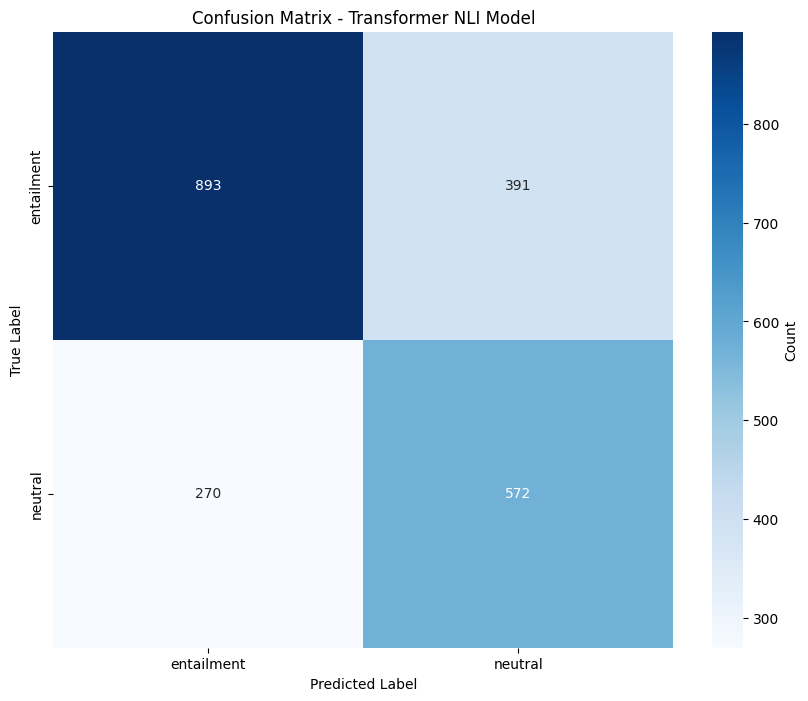


Classification Report:
              precision    recall  f1-score   support

  entailment       0.77      0.70      0.73      1284
     neutral       0.59      0.68      0.63       842

    accuracy                           0.69      2126
   macro avg       0.68      0.69      0.68      2126
weighted avg       0.70      0.69      0.69      2126



In [ ]:
class_names = ['entailment', 'neutral']

print("\nGenerating confusion matrix...")
plot_confusion_matrix(
    test_labels,
    test_preds,
    class_names=class_names,
    save_path='transformer_small_confusion_matrix.png'
)

# Ablation for Model 3: Encoder only transformer model with LearnedPositionalEncoder

In [ ]:
print("\nConfiguring Small Transformer Model (Sinusoidal PE)...")

LPE_config_small = NLIConfig(
    vocab_size=max(vocab_transformer.values()) + 1,  # Fix: use max token ID + 1 instead of len(vocab)
    d_model=256,
    n_layers=4,
    n_heads=8,
    d_ff=1024,
    max_seq_len=MAX_SEQ_LEN,
    num_labels=3,
    dropout=0.1,
    attention_dropout=0.1,
    pad_token_id=vocab_transformer['[PAD]'],
    cls_token_id=vocab_transformer['[CLS]'],
    sep_token_id=vocab_transformer['[SEP]'],
    unk_token_id=vocab_transformer['[UNK]'],
    pos_encoding_type='learned',
    trace_shapes=False
)

model3_transformer_LPE_small = TransformerForNLI(LPE_config_small)
print_model_summary(model3_transformer_LPE_small, LPE_config_small)


Configuring Small Transformer Model (Sinusoidal PE)...
MODEL SUMMARY - Transformer for NLI
Architecture: Encoder-Only Transformer (BERT-style)
Task: Natural Language Inference (3-way classification)

Configuration:
  Vocabulary Size: 21,523
  Model Dimension (d_model): 256
  Number of Layers: 4
  Number of Heads: 8
  Feed-Forward Dimension: 1024
  Max Sequence Length: 128
  Dropout: 0.1
  Positional Encoding: learned

Parameters:
  Total Parameters: 8,764,675
  Trainable Parameters: 8,764,675


### Training

In [ ]:
import gc, torch
gc.collect()
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nTraining on: {device}")

NUM_EPOCHS = 10
LEARNING_RATE = 3e-4
WEIGHT_DECAY = 0.01
WARMUP_STEPS = 100

print("\nStarting training...")
print(f"Epochs: {NUM_EPOCHS}, LR: {LEARNING_RATE}, Warmup: {WARMUP_STEPS} steps")
print("="*70)

history_small = train_transformer_nli(
    model=model3_transformer_LPE_small,
    train_loader=train_loader_tf,
    val_loader=val_loader_tf,
    num_epochs=NUM_EPOCHS,
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    warmup_steps=WARMUP_STEPS,
    device=device,
    save_path='transformer_nli_LPE_small_best.pt'
)

print("\n✓ Training completed!")


Training on: cuda

Starting training...
Epochs: 10, LR: 0.0003, Warmup: 100 steps
Training on device: cuda
Model parameters: 8,764,675

Epoch 1/10
--------------------------------------------------


Evaluating: 100%|██████████| 41/41 [00:00<00:00, 152.75it/s]


Train Loss: 1.1244, Train Acc: 0.0135
Val Loss: 1.1290, Val Acc: 0.0000
Learning Rate: 0.000003

Epoch 2/10
--------------------------------------------------


Evaluating: 100%|██████████| 41/41 [00:00<00:00, 134.65it/s]


Train Loss: 0.7429, Train Acc: 0.6255
Val Loss: 0.7491, Val Acc: 0.4962
Learning Rate: 0.000006
✓ Saved best model (val_acc: 0.4962)

Epoch 3/10
--------------------------------------------------


Evaluating: 100%|██████████| 41/41 [00:00<00:00, 154.89it/s]


Train Loss: 0.6640, Train Acc: 0.6329
Val Loss: 0.7341, Val Acc: 0.4962
Learning Rate: 0.000009

Epoch 4/10
--------------------------------------------------


Evaluating: 100%|██████████| 41/41 [00:00<00:00, 157.01it/s]


Train Loss: 0.5361, Train Acc: 0.7434
Val Loss: 0.7011, Val Acc: 0.6472
Learning Rate: 0.000012
✓ Saved best model (val_acc: 0.6472)

Epoch 5/10
--------------------------------------------------


Evaluating: 100%|██████████| 41/41 [00:00<00:00, 159.36it/s]


Train Loss: 0.4369, Train Acc: 0.8125
Val Loss: 0.7218, Val Acc: 0.6633
Learning Rate: 0.000015
✓ Saved best model (val_acc: 0.6633)

Epoch 6/10
--------------------------------------------------


Evaluating: 100%|██████████| 41/41 [00:00<00:00, 140.80it/s]


Train Loss: 0.3984, Train Acc: 0.8356
Val Loss: 0.7573, Val Acc: 0.6580
Learning Rate: 0.000018

Epoch 7/10
--------------------------------------------------


Evaluating: 100%|██████████| 41/41 [00:00<00:00, 133.72it/s]


Train Loss: 0.3665, Train Acc: 0.8522
Val Loss: 0.8060, Val Acc: 0.6541
Learning Rate: 0.000021

Epoch 8/10
--------------------------------------------------


Evaluating: 100%|██████████| 41/41 [00:00<00:00, 157.84it/s]


Train Loss: 0.3432, Train Acc: 0.8613
Val Loss: 0.8292, Val Acc: 0.6557
Learning Rate: 0.000024

Epoch 9/10
--------------------------------------------------


Evaluating: 100%|██████████| 41/41 [00:00<00:00, 157.27it/s]


Train Loss: 0.3138, Train Acc: 0.8761
Val Loss: 0.8372, Val Acc: 0.6403
Learning Rate: 0.000027

Epoch 10/10
--------------------------------------------------


Evaluating: 100%|██████████| 41/41 [00:00<00:00, 154.91it/s]

Train Loss: 0.2923, Train Acc: 0.8866
Val Loss: 0.8612, Val Acc: 0.6603
Learning Rate: 0.000030

Training completed! Best validation accuracy: 0.6633

✓ Training completed!


### Based on masking

In [ ]:
# for ablation study, we can use the no_mask as well
def no_mask(T: int, device: torch.device)->torch.Tensor:
    return torch.zeros(1, 1, T, T, dtype=torch.bool, device=device)

no mask should cause data leakage but can be used as our baseline

In [ ]:
def random_mask(T: int, device: torch.device, mask_prob: float = 0.15)->torch.Tensor:
    mask = torch.rand(1,1,T,T, device=device) < mask_prob
    return mask

Testing how our model handles random occlusion. Can be useful when exploring the robustness or masked language modelling
Can simulate missing information

### Cleanup for GPU

In [ ]:
import gc, torch
gc.collect()
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()


# Model 4: Encoder Transformer along with cross attention to BiLSTM
trying to get the NLI Task executed with encoder-biLstm classification architechture

## Architecture Overview

Sequential hybrid model where:

1. Transformer Encoder processes input → produces contextual representations
2. BiLSTM Encoder processes input → produces sequential features
3. Cross-Attention: Transformer queries attend to BiLSTM keys/values
4. Gating Mechanism: Weighted fusion of Transformer and cross-attended features
5. Classification Head: Standard NLI pooling + classification

## Cross Attention

In [ ]:
# Cross-Attention Module for Model 4

class CrossAttentionLayer(nn.Module):
    """
    Multi-head cross-attention where queries come from Transformer and
    keys/values come from BiLSTM.

    Args:
        d_model: dimension of transformer features
        bilstm_dim: dimension of BiLSTM features (2 * hidden_dim for bidirectional)
        n_heads: number of attention heads
        dropout: dropout rate
    """

    def __init__(self, d_model: int, bilstm_dim: int, n_heads: int = 8, dropout: float = 0.1):
        super().__init__()
        assert d_model % n_heads == 0, "d_model must be divisible by n_heads"

        self.d_model = d_model
        self.bilstm_dim = bilstm_dim
        self.n_heads = n_heads
        self.d_head = d_model // n_heads

        # Query projection from Transformer features
        self.q_proj = nn.Linear(d_model, d_model, bias=False)

        # Key and Value projections from BiLSTM features
        self.k_proj = nn.Linear(bilstm_dim, d_model, bias=False)
        self.v_proj = nn.Linear(bilstm_dim, d_model, bias=False)

        # Output projection
        self.out_proj = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, query: torch.Tensor, key: torch.Tensor, value: torch.Tensor,
                mask: torch.Tensor = None) -> torch.Tensor:
        """
        Args:
            query: Transformer features (B, T_q, d_model)
            key: BiLSTM features (B, T_k, bilstm_dim)
            value: BiLSTM features (B, T_v, bilstm_dim)
            mask: attention mask (B, T_k) - True for positions to mask
        Returns:
            cross_attended: (B, T_q, d_model)
        """
        B, T_q, _ = query.shape
        T_k = key.shape[1]

        # Project and reshape for multi-head attention
        Q = self.q_proj(query).view(B, T_q, self.n_heads, self.d_head).transpose(1, 2)
        K = self.k_proj(key).view(B, T_k, self.n_heads, self.d_head).transpose(1, 2)
        V = self.v_proj(value).view(B, T_k, self.n_heads, self.d_head).transpose(1, 2)

        # Scaled dot-product attention
        scale = 1.0 / math.sqrt(self.d_head)
        attention_scores = torch.matmul(Q, K.transpose(-2, -1)) * scale

        # Apply mask if provided
        if mask is not None:
            mask = mask.unsqueeze(1).unsqueeze(2)  # (B, 1, 1, T_k)
            attention_scores = attention_scores.masked_fill(mask, float('-inf'))

        # Softmax and apply to values
        attention_weights = F.softmax(attention_scores, dim=-1)
        attention_weights = self.dropout(attention_weights)
        context = torch.matmul(attention_weights, V)

        # Concatenate heads and project
        context = context.transpose(1, 2).contiguous().view(B, T_q, self.d_model)
        output = self.out_proj(context)

        return output

print("CrossAttentionLayer implemented")

CrossAttentionLayer implemented


### Implementing GatingFusion

In [ ]:
# Gating Fusion Module for Model 4

class GatingFusion(nn.Module):
    """
    Learnable gating mechanism for weighted feature combination.
    Combines transformer features with cross-attended BiLSTM features.

    Args:
        d_model: feature dimension
        dropout: dropout rate
    """

    def __init__(self, d_model: int, dropout: float = 0.1):
        super().__init__()
        self.d_model = d_model

        # Gate computation: takes concatenated features and outputs gate values
        self.gate = nn.Sequential(
            nn.Linear(d_model * 2, d_model),
            nn.Sigmoid()
        )

        # Layer normalization for stability
        self.layer_norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, transformer_feat: torch.Tensor, cross_attended_feat: torch.Tensor) -> torch.Tensor:
        """
        Args:
            transformer_feat: features from transformer encoder (B, T, d_model)
            cross_attended_feat: cross-attended features (B, T, d_model)
        Returns:
            fused: gated combination of features (B, T, d_model)
        """
        # Concatenate features
        combined = torch.cat([transformer_feat, cross_attended_feat], dim=-1)

        # Compute gate values (B, T, d_model)
        g = self.gate(combined)

        # Weighted combination: g * transformer + (1-g) * cross_attended
        fused = g * transformer_feat + (1 - g) * cross_attended_feat

        # Apply dropout and layer norm
        fused = self.dropout(fused)
        fused = self.layer_norm(fused)

        return fused

print("GatingFusion implemented")

GatingFusion implemented


In [ ]:
# Complete Hybrid Model: Transformer-BiLSTM with Cross-Attention

class TransformerBiLSTMCrossAttn(nn.Module):
    """
    Hybrid NLI model combining Transformer Encoder, BiLSTM, Cross-Attention, and Gating Fusion.

    Architecture:
    1. Shared embedding layer (GloVe)
    2. Parallel encoding: Transformer + BiLSTM
    3. Cross-attention: Transformer attends to BiLSTM
    4. Gating fusion of features
    5. Pooling and classification

    Args:
        embedding_matrix: pretrained embeddings
        d_model: transformer dimension
        n_layers: number of transformer layers
        n_heads: number of attention heads
        d_ff: feed-forward dimension
        lstm_hidden: BiLSTM hidden dimension
        num_classes: number of output classes
        pad_idx: padding token index
        dropout: dropout rate
    """

    def __init__(self, embedding_matrix, d_model=256, n_layers=3, n_heads=8,
                 d_ff=1024, lstm_hidden=128, num_classes=2, pad_idx=0, dropout=0.3):
        super().__init__()

        num_embeddings, embed_dim = embedding_matrix.size()
        self.d_model = d_model
        self.pad_idx = pad_idx

        # Shared embedding layer
        self.embedding = nn.Embedding.from_pretrained(
            embedding_matrix, freeze=False, padding_idx=pad_idx
        )

        # Project embeddings to d_model if needed
        self.embed_proj = nn.Linear(embed_dim, d_model) if embed_dim != d_model else nn.Identity()

        # Transformer Encoder (reuse from notebook)
        self.transformer_layers = nn.ModuleList([
            TransformerEncoderBlock(d_model=d_model, n_heads=n_heads,
                                   d_ff=d_ff, dropout=dropout)
            for _ in range(n_layers)
        ])

        # BiLSTM Encoder
        self.bilstm = nn.LSTM(embed_dim, lstm_hidden, batch_first=True,
                             bidirectional=True, dropout=dropout if n_layers > 1 else 0)
        self.bilstm_dim = lstm_hidden * 2  # Bidirectional

        # Cross-Attention: Transformer attends to BiLSTM
        self.cross_attention = CrossAttentionLayer(
            d_model=d_model, bilstm_dim=self.bilstm_dim,
            n_heads=n_heads, dropout=dropout
        )

        # Gating Fusion
        self.gating_fusion = GatingFusion(d_model=d_model, dropout=dropout)

        # Pooling
        self.pool = nn.AdaptiveMaxPool1d(1)

        # Classification head
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(d_model * 3, 256),  # [prem, hyp, |prem-hyp|]
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, num_classes)
        )

    def encode_sequence(self, x: torch.Tensor) -> tuple:
        """
        Encode a sequence through both Transformer and BiLSTM, then fuse.

        Args:
            x: token IDs (B, L)
        Returns:
            fused_features: (B, L, d_model)
        """
        # Embedding
        emb = self.embedding(x)  # (B, L, embed_dim)

        # Transformer path
        trans_feat = self.embed_proj(emb)  # (B, L, d_model)
        for layer in self.transformer_layers:
            trans_feat = layer(trans_feat)  # (B, L, d_model)

        # BiLSTM path
        bilstm_feat, _ = self.bilstm(emb)  # (B, L, bilstm_dim)

        # Cross-attention: Transformer attends to BiLSTM
        # Create padding mask
        mask = (x == self.pad_idx)  # (B, L)
        cross_attended = self.cross_attention(
            query=trans_feat,
            key=bilstm_feat,
            value=bilstm_feat,
            mask=mask
        )  # (B, L, d_model)

        # Gating fusion
        fused = self.gating_fusion(trans_feat, cross_attended)  # (B, L, d_model)

        return fused

    def pool_features(self, features: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
        """
        Pool sequence features to fixed-size vector using max pooling.

        Args:
            features: (B, L, d_model)
            mask: (B, L) padding mask
        Returns:
            pooled: (B, d_model)
        """
        # Mask out padding positions before pooling
        features = features.clone()

        features[mask] = -1e4  # Large negative value for max pooling

        # Max pooling: (B, d_model, L) -> (B, d_model, 1) -> (B, d_model)
        pooled = self.pool(features.permute(0, 2, 1)).squeeze(-1)
        return pooled

    def forward(self, premise: torch.Tensor, hypothesis: torch.Tensor) -> torch.Tensor:
        """
        Forward pass.

        Args:
            premise: (B, L_p)
            hypothesis: (B, L_h)
        Returns:
            logits: (B, num_classes)
        """
        # Encode both sequences
        prem_fused = self.encode_sequence(premise)  # (B, L_p, d_model)
        hyp_fused = self.encode_sequence(hypothesis)  # (B, L_h, d_model)

        # Pool to fixed vectors
        prem_mask = (premise == self.pad_idx)
        hyp_mask = (hypothesis == self.pad_idx)

        prem_vec = self.pool_features(prem_fused, prem_mask)  # (B, d_model)
        hyp_vec = self.pool_features(hyp_fused, hyp_mask)  # (B, d_model)

        # Combine: [premise, hypothesis, |premise - hypothesis|]
        combined = torch.cat([
            prem_vec,
            hyp_vec,
            torch.abs(prem_vec - hyp_vec)
        ], dim=-1)  # (B, d_model * 3)

        # Classify
        logits = self.classifier(combined)  # (B, num_classes)

        return logits

print("TransformerBiLSTMCrossAttn implemented")

TransformerBiLSTMCrossAttn implemented


## Data Loader Preparation

In [ ]:
BATCH_SIZE=8
MAX_SEQ_LEN=128

In [ ]:
# Model 4 needs separate premise and hypothesis tensors, not combined input_ids
# So we need to create a custom dataloader

from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

class Model4Dataset(Dataset):
    """
    Dataset for Model 4 that returns separate premise and hypothesis sequences.
    """
    def __init__(self, premises, hypotheses, labels, vocab, max_seq_len=128):
        self.premises = premises
        self.hypotheses = hypotheses
        self.labels = labels
        self.vocab = vocab
        self.max_seq_len = max_seq_len

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Tokenize and truncate premise
        prem_tokens = self.premises[idx][:self.max_seq_len]
        prem_ids = [self.vocab.get(token, self.vocab['<unk>']) for token in prem_tokens]

        # Tokenize and truncate hypothesis
        hyp_tokens = self.hypotheses[idx][:self.max_seq_len]
        hyp_ids = [self.vocab.get(token, self.vocab['<unk>']) for token in hyp_tokens]

        return (
            torch.tensor(prem_ids, dtype=torch.long),
            torch.tensor(hyp_ids, dtype=torch.long),
            self.labels[idx]
        )

def model4_collate_fn(batch, pad_idx=0):
    """
    Collate function for Model 4 with dynamic padding.
    """
    premises, hypotheses, labels = zip(*batch)

    # Pad sequences
    premises_padded = pad_sequence(premises, batch_first=True, padding_value=pad_idx)
    hypotheses_padded = pad_sequence(hypotheses, batch_first=True, padding_value=pad_idx)
    labels_tensor = torch.tensor(labels, dtype=torch.long)

    return premises_padded, hypotheses_padded, labels_tensor

# Create datasets
train_dataset_m4 = Model4Dataset(
    premises=train_df['premise_tokens'].tolist(),
    hypotheses=train_df['hypothesis_tokens'].tolist(),
    labels=train_df['label_id'].tolist(),
    vocab=vocab,
    max_seq_len=MAX_SEQ_LEN
)

val_dataset_m4 = Model4Dataset(
    premises=val_df['premise_tokens'].tolist(),
    hypotheses=val_df['hypothesis_tokens'].tolist(),
    labels=val_df['label_id'].tolist(),
    vocab=vocab,
    max_seq_len=MAX_SEQ_LEN
)

test_dataset_m4 = Model4Dataset(
    premises=test_df['premise_tokens'].tolist(),
    hypotheses=test_df['hypothesis_tokens'].tolist(),
    labels=test_df['label_id'].tolist(),
    vocab=vocab,
    max_seq_len=MAX_SEQ_LEN
)

# Create dataloaders with proper collate function
BATCH_SIZE = 8

train_loader_m4 = DataLoader(
    train_dataset_m4,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=lambda batch: model4_collate_fn(batch, pad_idx=vocab["<pad>"])
)

val_loader_m4 = DataLoader(
    val_dataset_m4,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=lambda batch: model4_collate_fn(batch, pad_idx=vocab["<pad>"])
)

test_loader_m4 = DataLoader(
    test_dataset_m4,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=lambda batch: model4_collate_fn(batch, pad_idx=vocab["<pad>"])
)

print("="*60)
print("Model 4 DataLoaders Created")
print("="*60)
print(f"Batch Size: {BATCH_SIZE}")
print(f"Max Sequence Length: {MAX_SEQ_LEN}")
print(f"Train batches: {len(train_loader_m4)}")
print(f"Val batches: {len(val_loader_m4)}")
print(f"Test batches: {len(test_loader_m4)}")
print("="*60)
MAX_SEQ_LEN=128

Model 4 DataLoaders Created
Batch Size: 8
Max Sequence Length: 128
Train batches: 2884
Val batches: 163
Test batches: 266


In [ ]:
# Note: train_loader_tf, val_loader_tf are for transformer models that use combined sequences
# Model 4 uses separate premise/hypothesis, so we created train_loader_m4, val_loader_m4 above

print("DataLoader setup complete!")
print("- train_loader_m4, val_loader_m4, test_loader_m4: For Model 4 (separate sequences)")
print("- train_loader_tf, val_loader_tf, test_loader_tf: For other transformer models (combined sequences)")

DataLoader setup complete!
- train_loader_m4, val_loader_m4, test_loader_m4: For Model 4 (separate sequences)
- train_loader_tf, val_loader_tf, test_loader_tf: For other transformer models (combined sequences)


## Training Model

In [ ]:
# Initialize Model 4: Transformer-BiLSTM with Cross-Attention

# Hyperparameters
d_model = 64          # Transformer dimension
n_layers = 1           # Number of transformer layers
n_heads = 2           # Number of attention heads
d_ff = 128            # Feed-forward dimension
lstm_hidden = 32      # BiLSTM hidden dimension
num_classes = len(label_map)  # Number of classes (2: entailment, not_entailment)
dropout = 0.2

# Initialize model
model4_TransBiLSTM_CrossAttn = TransformerBiLSTMCrossAttn(
    embedding_matrix=embedding_matrix,
    d_model=d_model,
    n_layers=n_layers,
    n_heads=n_heads,
    d_ff=d_ff,
    lstm_hidden=lstm_hidden,
    num_classes=num_classes,
    pad_idx=vocab["<pad>"],
    dropout=dropout
).to(DEVICE)

# Print model info
total_params = sum(p.numel() for p in model4_TransBiLSTM_CrossAttn.parameters())
trainable_params = sum(p.numel() for p in model4_TransBiLSTM_CrossAttn.parameters() if p.requires_grad)

print("="*60)
print("Model 4: Transformer-BiLSTM with Cross-Attention")
print("="*60)
print(f"Architecture:")
print(f"  - Transformer: {n_layers} layers, {n_heads} heads, d_model={d_model}")
print(f"  - BiLSTM: hidden_dim={lstm_hidden}, bidirectional=True")
print(f"  - Cross-Attention: {n_heads} heads")
print(f"  - Gating Fusion: learnable gates")
print(f"\nParameters:")
print(f"  - Total: {total_params:,}")
print(f"  - Trainable: {trainable_params:,}")
print(f"\nDevice: {DEVICE}")
print("="*60)

Model 4: Transformer-BiLSTM with Cross-Attention
Architecture:
  - Transformer: 1 layers, 2 heads, d_model=64
  - BiLSTM: hidden_dim=32, bidirectional=True
  - Cross-Attention: 2 heads
  - Gating Fusion: learnable gates

Parameters:
  - Total: 2,160,538
  - Trainable: 2,160,538

Device: cuda


In [ ]:
from torch.optim import Adam
from tqdm import tqdm
import gc

# Training configuration
epochs = 5
learning_rate = 1e-3

# OPTIMIZATION 1: Reduce batch size further if needed
# Current: BATCH_SIZE=8, which should be OK with seq_len=128
# BATCH_SIZE = 4

# OPTIMIZATION 2: Enable gradient accumulation for effective larger batch size
accumulation_steps = 2  # Effective batch size = BATCH_SIZE * accumulation_steps = 8 * 4 = 32

optimizer = Adam(model4_TransBiLSTM_CrossAttn.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# Training history
train_losses_m4 = []
train_accs_m4 = []
val_losses_m4 = []
val_accs_m4 = []
best_val_acc_m4 = 0.0

print(f"\nTraining Configuration:")
print(f"  Epochs: {epochs}")
print(f"  Learning Rate: {learning_rate}")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Gradient Accumulation Steps: {accumulation_steps}")
print(f"  Effective Batch Size: {BATCH_SIZE * accumulation_steps}")
print(f"\nStarting training for Model 4...\n")

# Clear GPU cache before training
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    gc.collect()

for epoch in range(epochs):
    # Training phase
    model4_TransBiLSTM_CrossAttn.train()
    total_loss = 0
    correct = 0
    total = 0

    loop = tqdm(train_loader_m4, desc=f"Epoch {epoch+1}/{epochs}")

    optimizer.zero_grad()  # Reset gradients at start

    for batch_idx, (prem, hyp, lbl) in enumerate(loop):
        prem, hyp, lbl = prem.to(DEVICE), hyp.to(DEVICE), lbl.to(DEVICE)

        # Forward pass
        logits = model4_TransBiLSTM_CrossAttn(prem, hyp)
        loss = criterion(logits, lbl)

        # Normalize loss for gradient accumulation
        loss = loss / accumulation_steps

        # Backward pass
        loss.backward()

        # Update weights only every accumulation_steps
        if (batch_idx + 1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

        # Track metrics (use unnormalized loss for logging)
        total_loss += loss.item() * accumulation_steps
        preds = logits.argmax(dim=1)
        correct += (preds == lbl).sum().item()
        total += lbl.size(0)

        loop.set_postfix(loss=loss.item() * accumulation_steps, acc=correct/total)

    # Update optimizer if there are leftover gradients
    if (batch_idx + 1) % accumulation_steps != 0:
        optimizer.step()
        optimizer.zero_grad()

    train_loss = total_loss / len(train_loader_m4)
    train_acc = correct / total
    train_losses_m4.append(train_loss)
    train_accs_m4.append(train_acc)

    # Validation phase
    model4_TransBiLSTM_CrossAttn.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for prem, hyp, lbl in val_loader_m4:
            prem, hyp, lbl = prem.to(DEVICE), hyp.to(DEVICE), lbl.to(DEVICE)
            logits = model4_TransBiLSTM_CrossAttn(prem, hyp)
            loss = criterion(logits, lbl)

            val_loss += loss.item()
            preds = logits.argmax(dim=1)
            val_correct += (preds == lbl).sum().item()
            val_total += lbl.size(0)

    val_loss = val_loss / len(val_loader_m4)
    val_acc = val_correct / val_total
    val_losses_m4.append(val_loss)
    val_accs_m4.append(val_acc)

    print(f"\nEpoch {epoch+1}/{epochs}:")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Save best model
    if val_acc > best_val_acc_m4:
        best_val_acc_m4 = val_acc
        torch.save(model4_TransBiLSTM_CrossAttn.state_dict(),
                  sourceFolder/"models/trans_bilstm_crossattn_best.pt")
        print(f"  ✓ Best model saved (val_acc: {val_acc:.4f})")

    # Clear cache after each epoch
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    print()

print("Training complete!")
print(f"Best validation accuracy: {best_val_acc_m4:.4f}")



Training Configuration:
  Epochs: 5
  Learning Rate: 0.001
  Batch Size: 8
  Gradient Accumulation Steps: 2
  Effective Batch Size: 16

Starting training for Model 4...



Epoch 1/5: 100%|██████████| 2884/2884 [00:50<00:00, 56.75it/s, acc=0.633, loss=nan]



Epoch 1/5:
  Train Loss: nan, Train Acc: 0.6326
  Val Loss: nan, Val Acc: 0.4962
  ✓ Best model saved (val_acc: 0.4962)



Epoch 2/5: 100%|██████████| 2884/2884 [00:52<00:00, 54.95it/s, acc=0.633, loss=nan]



Epoch 2/5:
  Train Loss: nan, Train Acc: 0.6329
  Val Loss: nan, Val Acc: 0.4962



Epoch 3/5: 100%|██████████| 2884/2884 [00:51<00:00, 55.67it/s, acc=0.633, loss=nan]



Epoch 3/5:
  Train Loss: nan, Train Acc: 0.6329
  Val Loss: nan, Val Acc: 0.4962



Epoch 4/5: 100%|██████████| 2884/2884 [00:50<00:00, 56.63it/s, acc=0.633, loss=nan]



Epoch 4/5:
  Train Loss: nan, Train Acc: 0.6329
  Val Loss: nan, Val Acc: 0.4962



Epoch 5/5: 100%|██████████| 2884/2884 [00:51<00:00, 56.03it/s, acc=0.633, loss=nan]



Epoch 5/5:
  Train Loss: nan, Train Acc: 0.6329
  Val Loss: nan, Val Acc: 0.4962

Training complete!
Best validation accuracy: 0.4962
